In [5]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.stats import norm
from scipy import stats
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [6]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [7]:
MODELS = [os.path.join('analysis_noise_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_noise_v7.0'))]

In [8]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [9]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [10]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [11]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [12]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

# Sort the results by configs[model]['noise_level']
results = dict(sorted(results.items(), key=lambda x: configs[x[0]]['noise_level']))

In [13]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            # keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            # keys_to_remove = []
            # keys_to_remove.extend(['x', 'y'])

            # for k in keys_to_remove:
            #     del test_set_results['data'][k]

Loading analysis_noise_v7.0/v7.0_1e-3-noise results: 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]
Loading analysis_noise_v7.0/v7.0_1e-2-noise results: 100%|██████████| 4/4 [00:15<00:00,  3.92s/it]
Loading analysis_noise_v7.0/v7.0_1e-1-noise results: 100%|██████████| 4/4 [00:16<00:00,  4.09s/it]
Loading analysis_noise_v7.0/v7.0_5e-1-noise results: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]
Loading analysis_noise_v7.0/v7.0_1-noise results: 100%|██████████| 4/4 [00:15<00:00,  3.99s/it]


In [14]:
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Filtering {model} results'):
        for k in test_set_results['data'].keys():
            test_set_results['data'][k] = test_set_results['data'][k][1:]

Filtering analysis_noise_v7.0/v7.0_1e-3-noise results: 100%|██████████| 4/4 [00:00<00:00, 743.93it/s]
Filtering analysis_noise_v7.0/v7.0_1e-2-noise results: 100%|██████████| 4/4 [00:00<00:00, 708.77it/s]
Filtering analysis_noise_v7.0/v7.0_1e-1-noise results: 100%|██████████| 4/4 [00:00<00:00, 794.68it/s]
Filtering analysis_noise_v7.0/v7.0_5e-1-noise results: 100%|██████████| 4/4 [00:00<00:00, 785.74it/s]
Filtering analysis_noise_v7.0/v7.0_1-noise results: 100%|██████████| 4/4 [00:00<00:00, 861.78it/s]


In [15]:
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Filtering {model} results'):
        for k in test_set_results['data'].keys():
            if 'residuals' in k:
                for i, residuals in enumerate(test_set_results['data'][k]):
                    if residuals is None:
                        test_set_results['data'][k][i] = np.full((configs[model]['n_support'], 1), np.nan)

Filtering analysis_noise_v7.0/v7.0_1e-3-noise results: 100%|██████████| 4/4 [00:00<00:00, 360.30it/s]
Filtering analysis_noise_v7.0/v7.0_1e-2-noise results: 100%|██████████| 4/4 [00:00<00:00, 363.45it/s]
Filtering analysis_noise_v7.0/v7.0_1e-1-noise results: 100%|██████████| 4/4 [00:00<00:00, 376.13it/s]
Filtering analysis_noise_v7.0/v7.0_5e-1-noise results: 100%|██████████| 4/4 [00:00<00:00, 358.99it/s]
Filtering analysis_noise_v7.0/v7.0_1-noise results: 100%|██████████| 4/4 [00:00<00:00, 351.27it/s]


In [16]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 7291.27it/s]


In [17]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' in data:
            max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

            for j in range(beam_width):
                padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
                data[f'_beam_{j + 1}'] = np.array(padded_beam)


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_9937/1962314347.py:14: RuntimeWarning: All-NaN slice encountered
  results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


In [18]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 22.26it/s]


In [19]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        test_set_results['data']['FVU-eps_accuracy'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['log_fvu'] = np.array([np.log10(1 - r2 + np.finfo(np.float32).eps) for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['fvu'] = np.array([1 - r2 for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['is_finite'] = np.array([np.isfinite(r2) for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['y_std'] = np.array([np.std(y) for y in test_set_results['data']['y']])
        test_set_results['data']['noise'] = np.array([y_noisy - y for y_noisy, y in zip(test_set_results['data']['y_noisy'], test_set_results['data']['y'])])
        test_set_results['data']['noise_std'] = np.array([np.std(noise) for noise in test_set_results['data']['noise']])
        test_set_results['data']['residuals_std'] = np.array([np.std(residuals) for residuals in test_set_results['data']['residuals_best_beam']])
        test_set_results['data']['residuals_scaled'] = np.array([residuals / y_std for residuals, y_std in zip(test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std'])])
        test_set_results['data']['is_overfit'] = np.array([residuals_std < noise_std for residuals_std, noise_std in zip(test_set_results['data']['residuals_std'], test_set_results['data']['noise_std'])])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = np.array([np.log10(ppl) for ppl in test_set_results['data']['perplexity']])
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

/tmp/ipykernel_9937/927759427.py:12: RuntimeWarning: divide by zero encountered in divide
  test_set_results['data']['residuals_scaled'] = np.array([residuals / y_std for residuals, y_std in zip(test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std'])])
/tmp/ipykernel_9937/927759427.py:12: RuntimeWarning: invalid value encountered in divide
  test_set_results['data']['residuals_scaled'] = np.array([residuals / y_std for residuals, y_std in zip(test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std'])])


In [20]:
def get_quantiles_correct(noise, residuals, y_std, noise_level):
    # Scale residuals and noise by y_std and noise_level to make them have std 1
    # Currently, noise ~ N(0, noise_level * y_std)
    # Therefore, revert this by dividing by y_std * noise_level to get N(0, 1)
    residuals_scaled = residuals / (y_std * noise_level)
    noise_scaled = noise / (y_std * noise_level)

    # The theoretical quantiles are the quantiles of the noise
    theoretical_quantiles = np.sort(noise_scaled)

    # The empirical quantiles are the quantiles of the residuals
    empirical_quantiles = np.sort(residuals_scaled)

    return theoretical_quantiles, empirical_quantiles

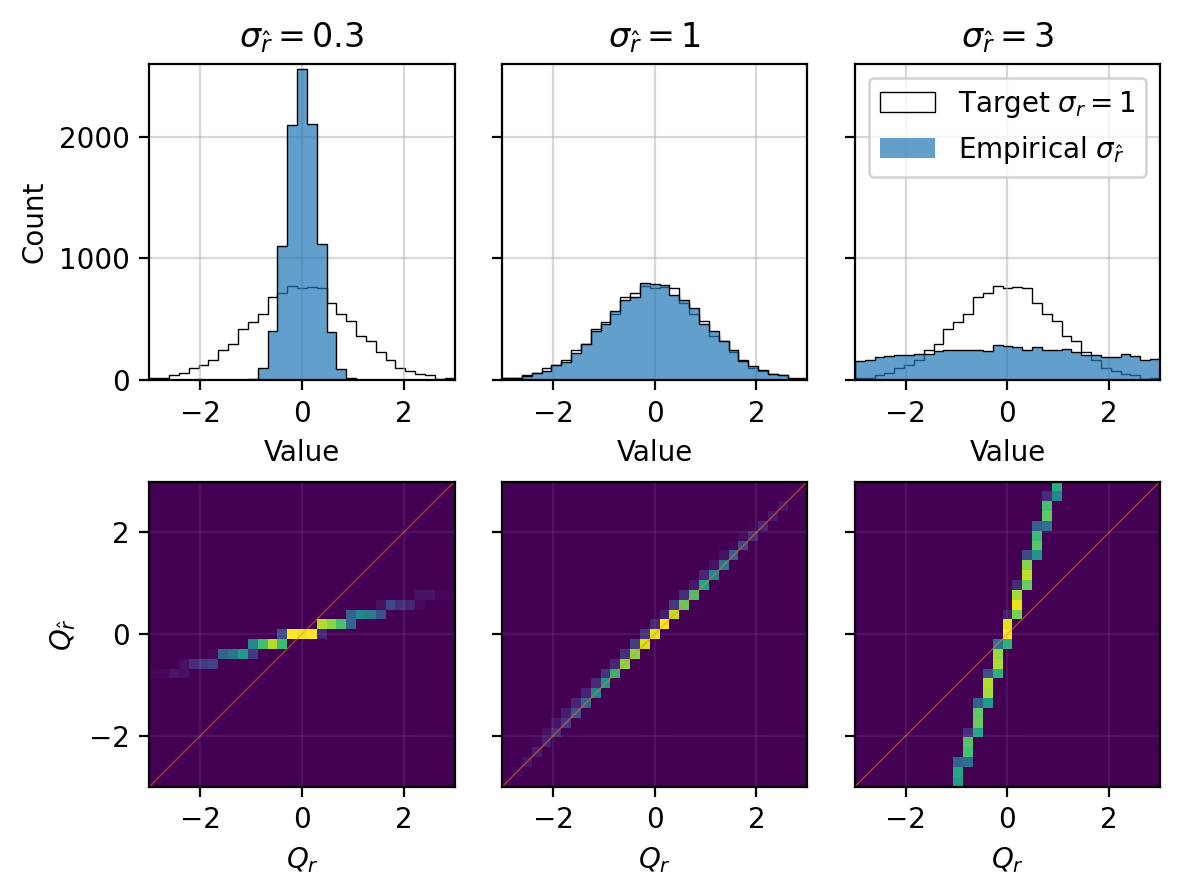

In [21]:
lim = 3
n_bins = 32
bins = np.linspace(-lim, lim, n_bins)

fig, axes = plt.subplots(2, 3, figsize=(6, 4.5), dpi=200)

target_std = 1
example_std_list = [0.3, 1, 3]

target_residuals = np.random.randn(10000)  # noise
example_residuals_list = [np.random.randn(10000) * std for std in example_std_list]  # residuals

for i, (ax, residuals) in enumerate(zip(axes[0], example_residuals_list)):
    ax.hist(target_residuals, bins=bins, histtype='step', color='black', linewidth=0.5, zorder=1, label='Target $\\sigma_r = 1$')
    ax.hist(residuals, bins=bins, alpha=0.7, zorder=2, label=f'Empirical $\\sigma_\hat{{r}}$', rasterized=True)
    ax.hist(residuals, bins=bins, histtype='step', color='black', linewidth=0.5, zorder=3)
    ax.set_ylim(0, 2600)

    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Count')

    ax.set_xlabel('Value')
    ax.grid(alpha=0.5, zorder=0)
    ax.set_xlim(-lim, lim)
    ax.set_title(f'$\\sigma_\hat{{r}} = {example_std_list[i]}$')
    
axes[0, 2].legend()

for i, (ax, residuals) in enumerate(zip(axes[1], example_residuals_list)):
    theoretical_quantiles, empirical_quantiles = get_quantiles_correct(target_residuals, residuals, 1, 1)
    ax.hist2d(theoretical_quantiles, empirical_quantiles, bins=bins, rasterized=True);

    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('$Q_{\\hat{r}}$')

    ax.set_xlabel('$Q_{r}$')
    ax.grid(alpha=0.1)
    ax.set_aspect('equal')

    # ax.plot([-lim, lim], [-lim, lim], color='w', linewidth=0.5, zorder=3, linestyle='--')
    
    # ax.plot([-lim, lim], [-lim, lim], color='k', linewidth=0.5, zorder=1)
    ax.plot([-lim, lim], [-lim, lim], color='tab:orange', linewidth=0.5, zorder=1, alpha=0.5)

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_qq_examples.svg'))

In [24]:
lim = 3
n_bins = 16
bins = np.linspace(-lim, lim, n_bins)

all_statistics = {}
all_statistics_lower = {}
all_statistics_upper = {}
all_theoretical_quantiles_list = {}
all_empirical_quantiles_list = {}

for i, (model, model_results) in enumerate(list(results.items())):
    for j, (test_set, test_set_results) in enumerate(tqdm(model_results.items(), desc=f'{model} {test_set}')):
        # Get the theoretical and empirical quantiles
        theoretical_quantiles_list = []
        empirical_quantiles_list = []
        for noise, residuals, y_std in zip(test_set_results['data']['noise'], test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std']):
            # noise = y_noisy - y
            # residuals = y_pred - y_noisy but want y_noisy - y_pred = -residuals
            theoretical_quantiles, empirical_quantiles = get_quantiles_correct(noise.flatten(), - residuals.flatten(), y_std, configs[model]['noise_level'])
            theoretical_quantiles_list.extend(theoretical_quantiles)
            empirical_quantiles_list.extend(empirical_quantiles)
        theoretical_quantiles_list = np.array(theoretical_quantiles_list)
        empirical_quantiles_list = np.array(empirical_quantiles_list)

        # Collect statistics
        statistics = {}
        statistics_lower = {}
        statistics_upper = {}
        for statistic_name, statistic_function in zip(['median', 'p5', 'p25', 'p75', 'p95'], [np.nanmedian, lambda x: np.nanpercentile(x, 5), lambda x: np.nanpercentile(x, 25), lambda x: np.nanpercentile(x, 75), lambda x: np.nanpercentile(x, 95)]):
            values_statistic_median = []
            values_statistic_lower = []
            values_statistic_upper = []
            for b in range(len(bins) - 1):
                mask = (theoretical_quantiles_list >= bins[b]) & (theoretical_quantiles_list < bins[b + 1])
                median, lower, upper = bootstrapped_metric_ci(empirical_quantiles_list[mask], statistic_function, n=1000)
                values_statistic_median.append(median)
                values_statistic_lower.append(lower)
                values_statistic_upper.append(upper)
            statistics[statistic_name] = np.array(values_statistic_median)
            statistics_lower[statistic_name] = np.array(values_statistic_lower)
            statistics_upper[statistic_name] = np.array(values_statistic_upper)

        all_statistics[(model, test_set)] = statistics
        all_statistics_lower[(model, test_set)] = statistics_lower
        all_statistics_upper[(model, test_set)] = statistics_upper
        all_theoretical_quantiles_list[(model, test_set)] = theoretical_quantiles_list
        all_empirical_quantiles_list[(model, test_set)] = empirical_quantiles_list

analysis_noise_v7.0/v7.0_1e-3-noise feynman:  75%|███████▌  | 3/4 [00:09<00:03,  3.25s/it]/tmp/ipykernel_9937/1564039059.py:5: RuntimeWarning: divide by zero encountered in divide
  residuals_scaled = residuals / (y_std * noise_level)
/tmp/ipykernel_9937/1564039059.py:6: RuntimeWarning: invalid value encountered in divide
  noise_scaled = noise / (y_std * noise_level)
/tmp/ipykernel_9937/1564039059.py:5: RuntimeWarning: invalid value encountered in divide
  residuals_scaled = residuals / (y_std * noise_level)
analysis_noise_v7.0/v7.0_1e-2-noise pool_15:  75%|███████▌  | 3/4 [00:08<00:02,  2.95s/it]/tmp/ipykernel_9937/1564039059.py:6: RuntimeWarning: divide by zero encountered in divide
  noise_scaled = noise / (y_std * noise_level)
analysis_noise_v7.0/v7.0_1-noise pool_15: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


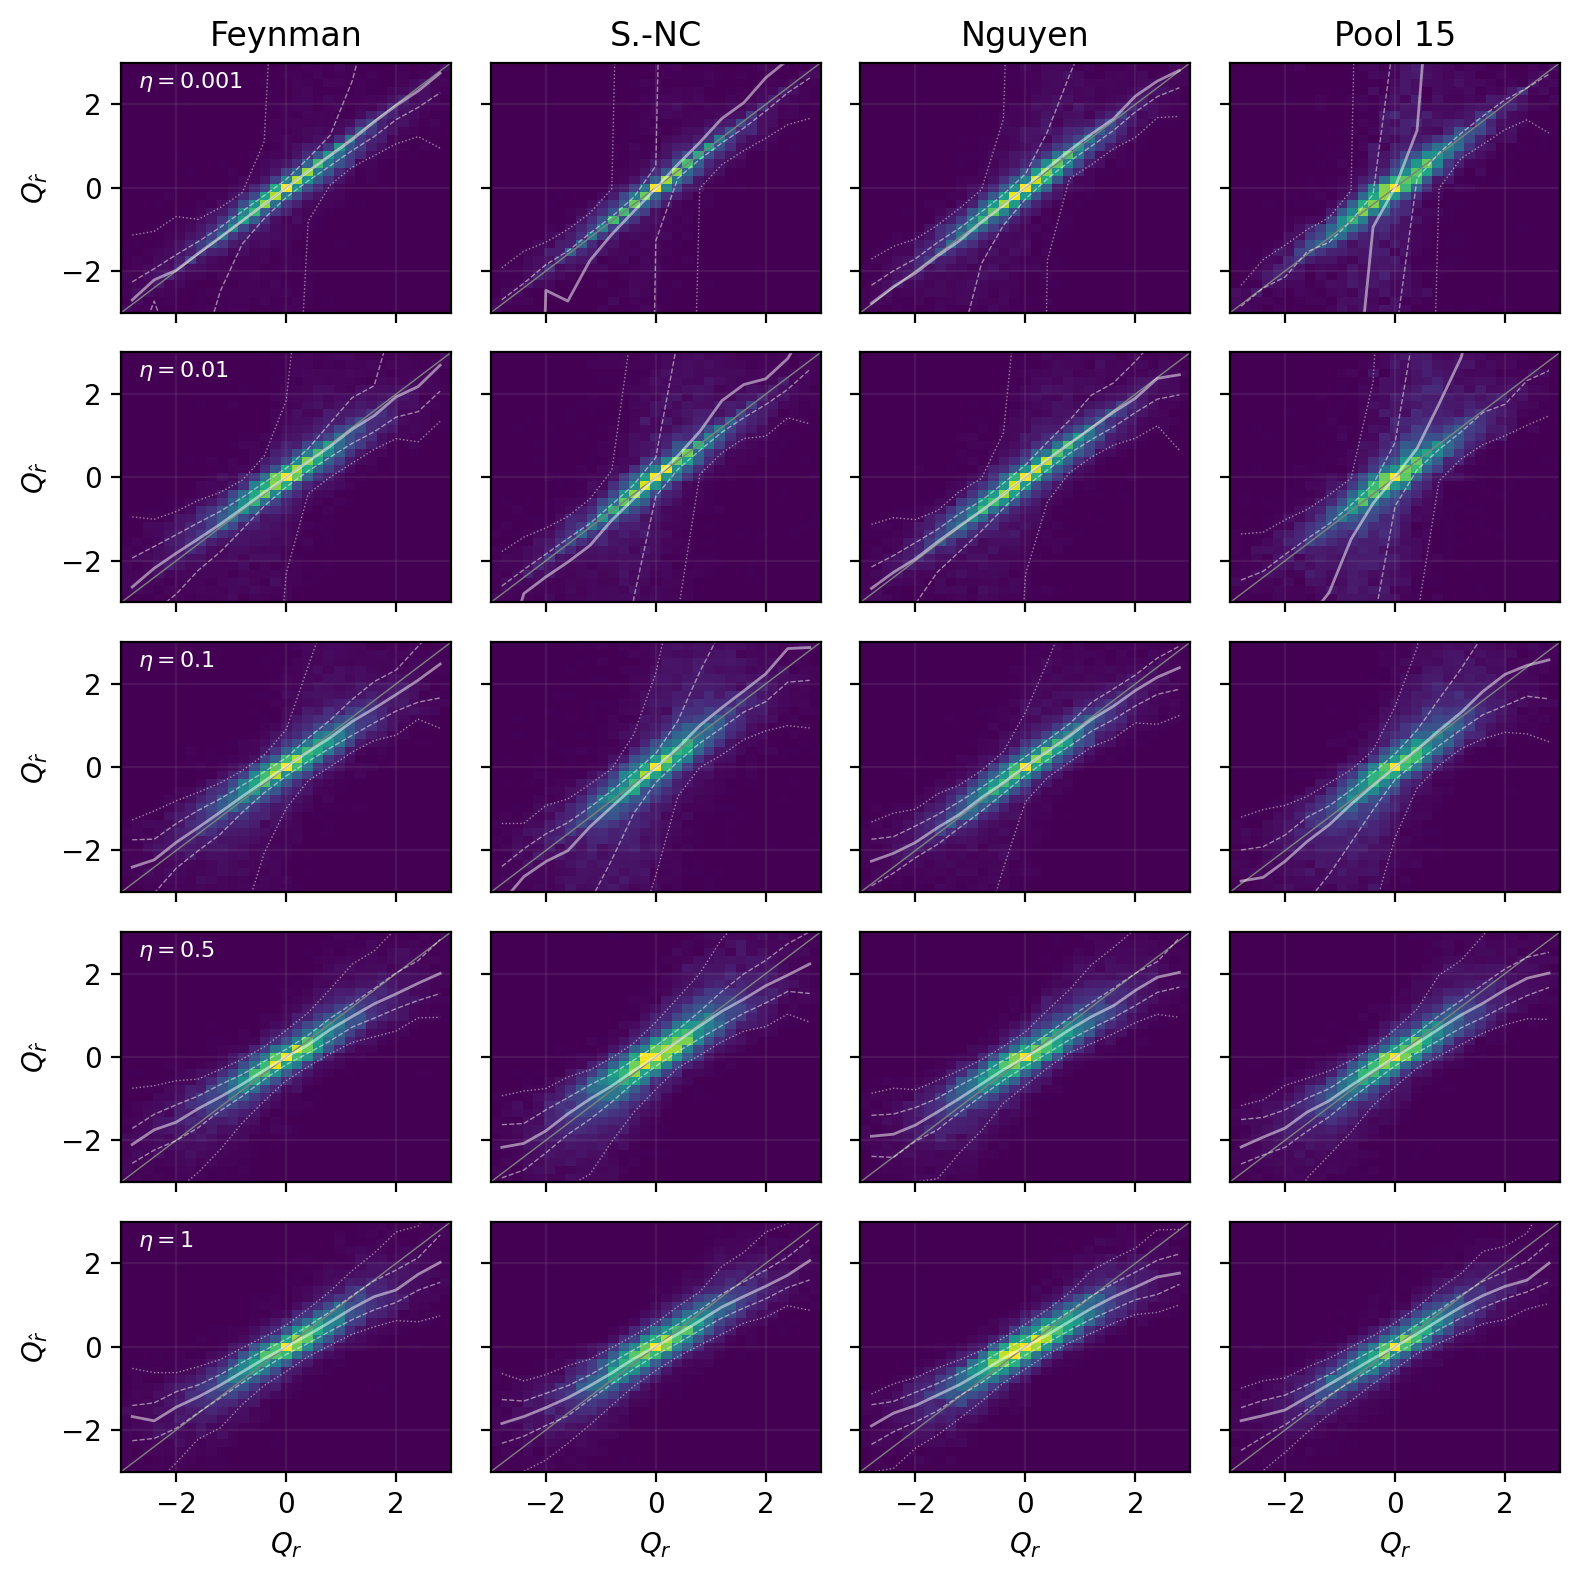

In [25]:
COLS = 4
ROWS = len(results)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2, ROWS * 1.6), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(list(results.items())):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        # color = plt.get_cmap('plasma')(i / (len(results)))

        statistics = all_statistics[(model, test_set)]
        statistics_lower = all_statistics_lower[(model, test_set)]
        statistics_upper = all_statistics_upper[(model, test_set)]
        theoretical_quantiles_list = all_theoretical_quantiles_list[(model, test_set)]
        empirical_quantiles_list = all_empirical_quantiles_list[(model, test_set)]

        ax.hist2d(theoretical_quantiles_list, empirical_quantiles_list, bins=np.linspace(-lim, lim, 32), rasterized=True)

        # ax.axhline(0, color='w', lw=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['median'], color="w", linewidth=1, alpha=0.5)
        # ax.fill_between((bins[1:] + bins[:-1]) / 2, statistics['p25'], statistics['p75'], color=color, alpha=0.1)
        # ax.fill_between((bins[1:] + bins[:-1]) / 2, statistics['p5'], statistics['p95'], color=color, alpha=0.1)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p25'], color="w", linestyle='--', linewidth=0.5, alpha=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p75'], color="w", linestyle='--', linewidth=0.5, alpha=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p5'], color="w", linestyle=':', linewidth=0.5, alpha=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p95'], color="w", linestyle=':', linewidth=0.5, alpha=0.5)

        ax.grid(alpha=0.1)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('$Q_{r}$')

        if j == 0:
            ax.set_ylabel('$Q_{\\hat{r}}$')
            ax.annotate(f'$\\eta = {configs[model]["noise_level"]}$', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8, color='w')

        ax.plot([-lim, lim], [-lim, lim], color='gray', linewidth=0.5, zorder=1)

        # if i - k * 4 == j:
        #     ax.legend(loc='lower right', ncol=1)

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_qq_discrepancy_all.svg'))

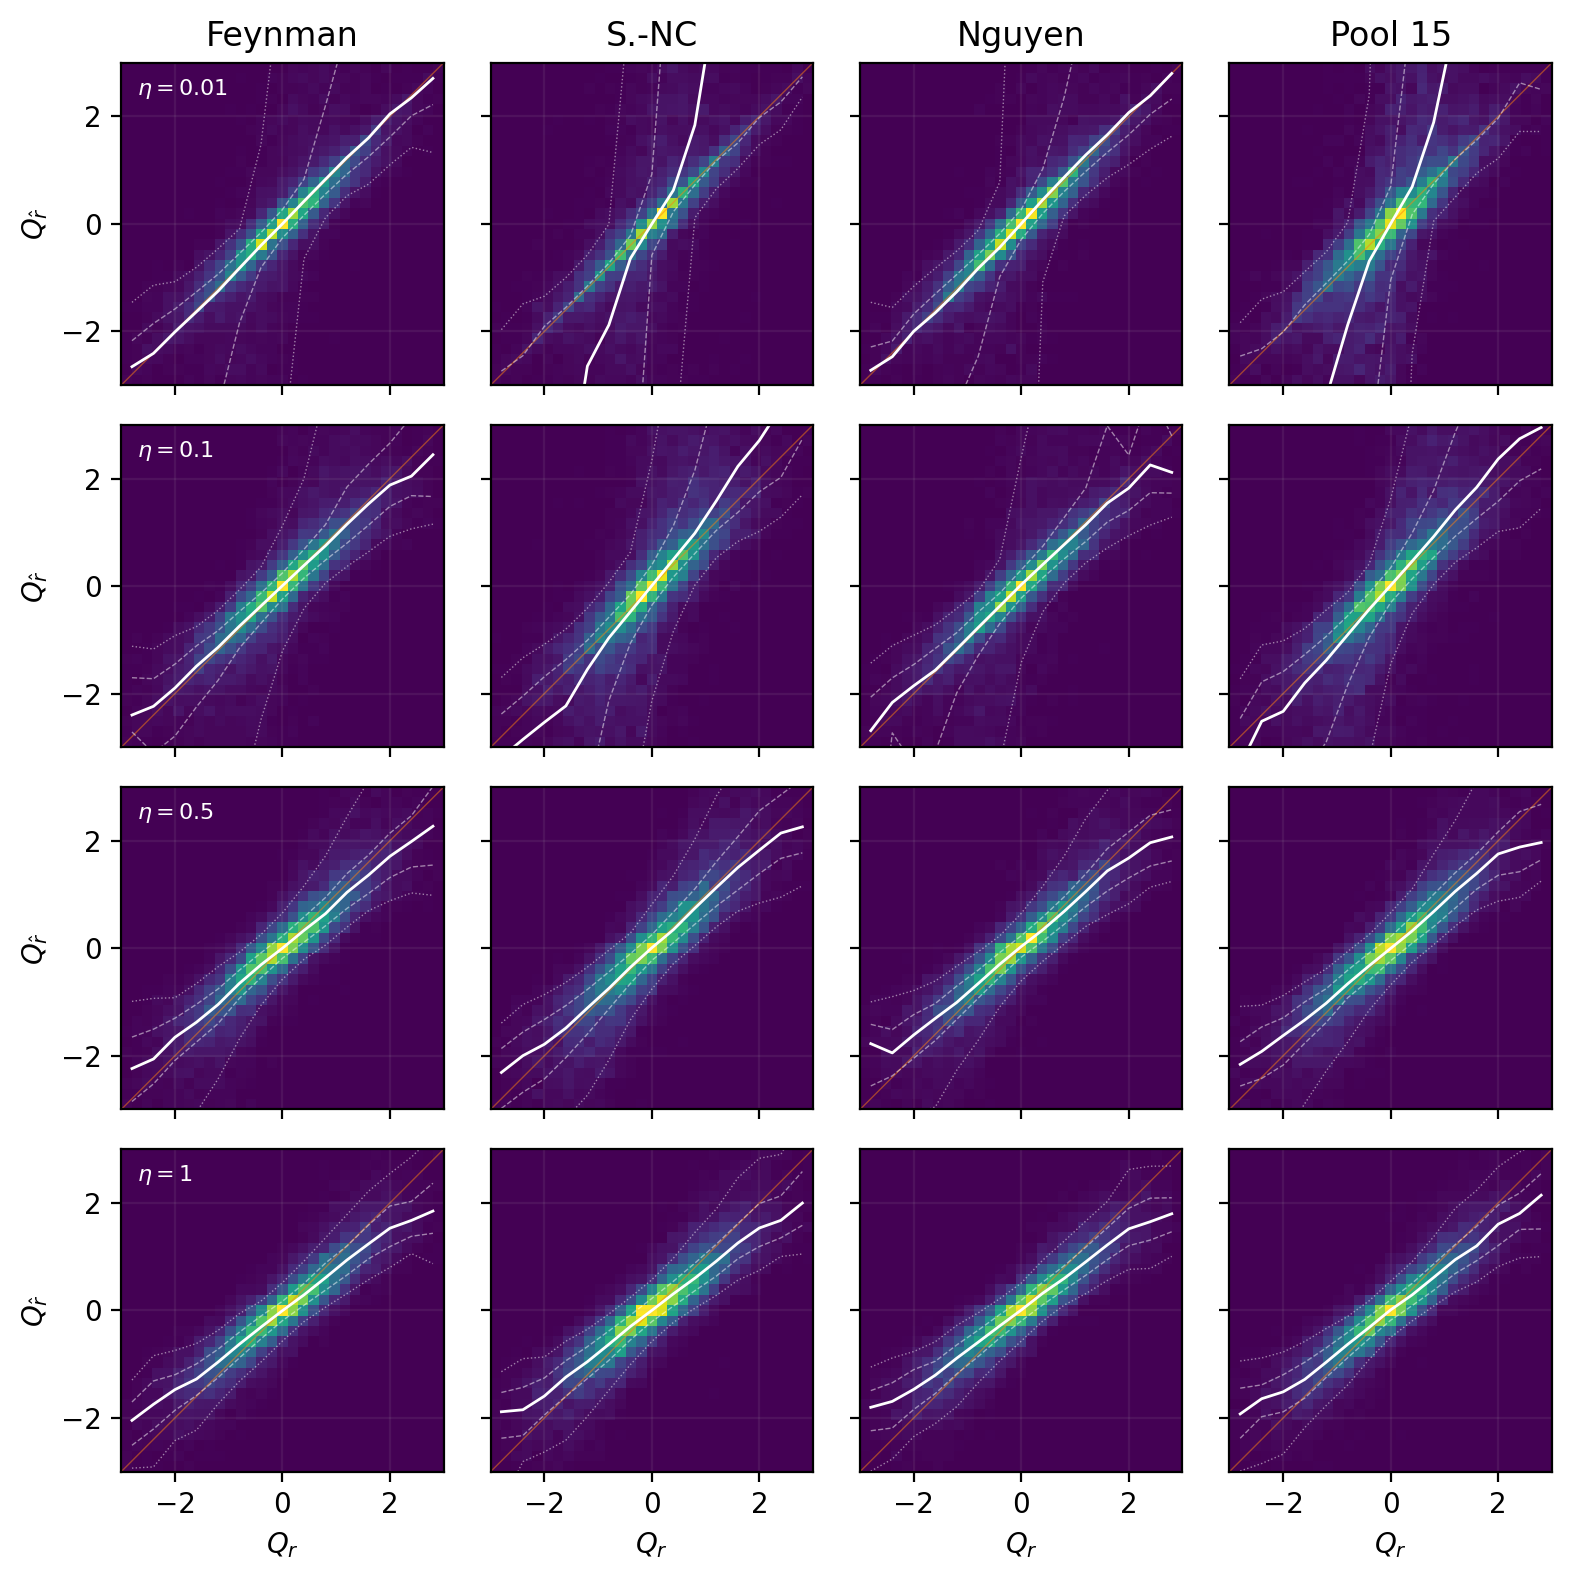

In [20]:
model_selection = ['analysis_noise/v6.0_1e-2-noise', 'analysis_noise/v6.0_1e-1-noise', 'analysis_noise/v6.0_5e-1-noise', 'analysis_noise/v6.0_1-noise']
results_selection = {k: results[k] for k in model_selection}

COLS = 4
ROWS = len(model_selection)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2, ROWS * 2), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(results_selection.items()):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        model_index_in_results = list(results.keys()).index(model)
        color = plt.get_cmap('plasma')(model_index_in_results / (len(results) - 1))

        statistics = all_statistics[(model, test_set)]
        statistics_lower = all_statistics_lower[(model, test_set)]
        statistics_upper = all_statistics_upper[(model, test_set)]
        theoretical_quantiles_list = all_theoretical_quantiles_list[(model, test_set)]
        empirical_quantiles_list = all_empirical_quantiles_list[(model, test_set)]

        ax.hist2d(theoretical_quantiles_list, empirical_quantiles_list, bins=np.linspace(-lim, lim, 32), rasterized=True)
        # ax.scatter(theoretical_quantiles_list, empirical_quantiles_list, s=1, color='k', alpha=0.1)

        # ax.axhline(0, color='w', lw=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['median'], color='w', linewidth=1)
        # ax.fill_between((bins[1:] + bins[:-1]) / 2, statistics['p25'], statistics['p75'], color='w', alpha=0.1)
        # ax.fill_between((bins[1:] + bins[:-1]) / 2, statistics['p5'], statistics['p95'], color='w', alpha=0.1)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p25'], color='w', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p75'], color='w', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p5'], color='w', linestyle=':', linewidth=0.5, alpha=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p95'], color='w', linestyle=':', linewidth=0.5, alpha=0.5)

        ax.grid(alpha=0.1)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)

        ax.set_aspect('equal')

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(model_selection) - 1:
            ax.set_xlabel('$Q_{r}$')

        if j == 0:
            ax.set_ylabel('$Q_{\\hat{r}}$')
            ax.annotate(f'$\\eta = {configs[model]["noise_level"]}$', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8, color='w')

        ax.plot([-lim, lim], [-lim, lim], color='tab:orange', linewidth=0.5, zorder=1, alpha=0.5)

        # if i - k * 4 == j:
        #     ax.legend(loc='lower right', ncol=1) 

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_qq_discrepancy_selection.svg'))

In [21]:
space = ExpressionSpace.from_config(get_path('configs', 'analysis_noise', 'v6.0_1-noise', 'expression_space.yaml'))

In [22]:
lim = 3
n_bins = 16
bins = np.linspace(-lim, lim, n_bins)

model = 'analysis_noise/v6.0_1e-6-noise'
test_set = 'feynman'

# Get the theoretical and empirical quantiles
theoretical_quantiles_list = []
empirical_quantiles_list = []
for noise, residuals, y_std in zip(results[model][test_set]['data']['noise'], - results[model][test_set]['data']['residuals_best_beam'], results[model][test_set]['data']['y_std']):
    theoretical_quantiles, empirical_quantiles = get_quantiles_correct(noise.flatten(), residuals.flatten(), y_std, configs[model]['noise_level'])
    theoretical_quantiles_list.append(theoretical_quantiles)
    empirical_quantiles_list.append(empirical_quantiles)
theoretical_quantiles_list = np.array(theoretical_quantiles_list)
empirical_quantiles_list = np.array(empirical_quantiles_list)

/tmp/ipykernel_1002/1564039059.py:5: RuntimeWarning: invalid value encountered in divide
  residuals_scaled = residuals / (y_std * noise_level)
/tmp/ipykernel_1002/1564039059.py:6: RuntimeWarning: invalid value encountered in divide
  noise_scaled = noise / (y_std * noise_level)


In [23]:
[i for i, x in enumerate(results[model][test_set]['data']['x']) if len(np.nonzero(x[0, 0])[0]) == 1][:10]

[11, 33, 50, 73, 95, 99, 106, 115, 165, 169]

In [24]:
i = 73

Text(0, 0.5, '$Q_{\\hat{r}}$')

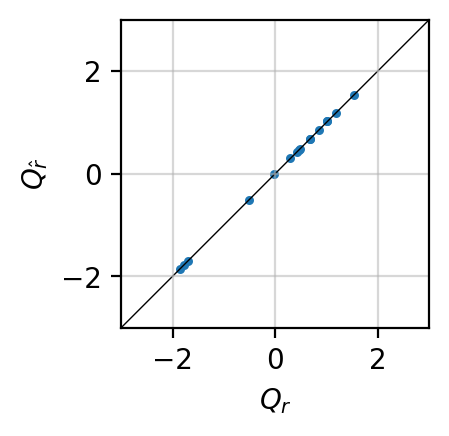

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)
ax.scatter(theoretical_quantiles_list[i], empirical_quantiles_list[i], s=5)
ax.plot([-lim, lim], [-lim, lim], color='k', linewidth=0.5, zorder=1)
ax.grid(alpha=0.5)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect('equal')
ax.set_xlabel('$Q_{r}$')
ax.set_ylabel('$Q_{\\hat{r}}$')

In [26]:
print(f"GT:   {space.tokenizer.decode(results[model][test_set]['data']['input_ids'][i], special_tokens=['<num>'])}")
# print(f"PRED: {space.tokenizer.decode(results[model][test_set]['data']['free_beam_1'][i])}")
print(f"F1:   {results[model][test_set]['data']['f1_score_best_beam'][i]}")
print(f"F1:   {results[model][test_set]['data']['FVU-eps_accuracy'][i]}")

GT:   ['pow2', 'sin', 'pow2', 'x2']
F1:   1.0
F1:   True


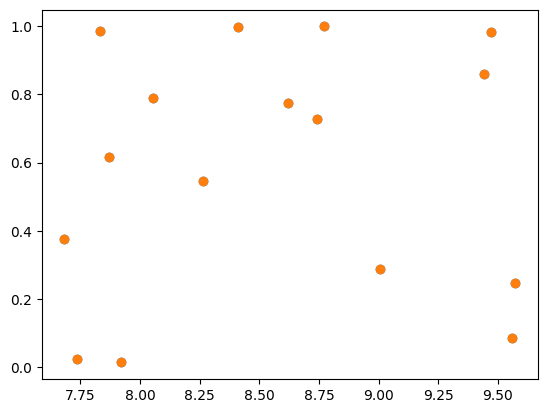

In [27]:
x = results[model][test_set]['data']['x'][i][0, :, np.nonzero(results[model][test_set]['data']['x'][i][0])[1][0]]
y = results[model][test_set]['data']['y'][i]
y_noisy = results[model][test_set]['data']['y_noisy'][i]
residuals = results[model][test_set]['data']['residuals_best_beam'][i]

plt.scatter(x, y)
# plt.scatter(x, y_noisy)
plt.scatter(x, y_noisy + residuals)

In [28]:
# (y_pred - y_noisy) + (y_noisy - y)
results[model][test_set]['data']['residuals_best_beam'][i] + results[model][test_set]['data']['noise'][i]

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

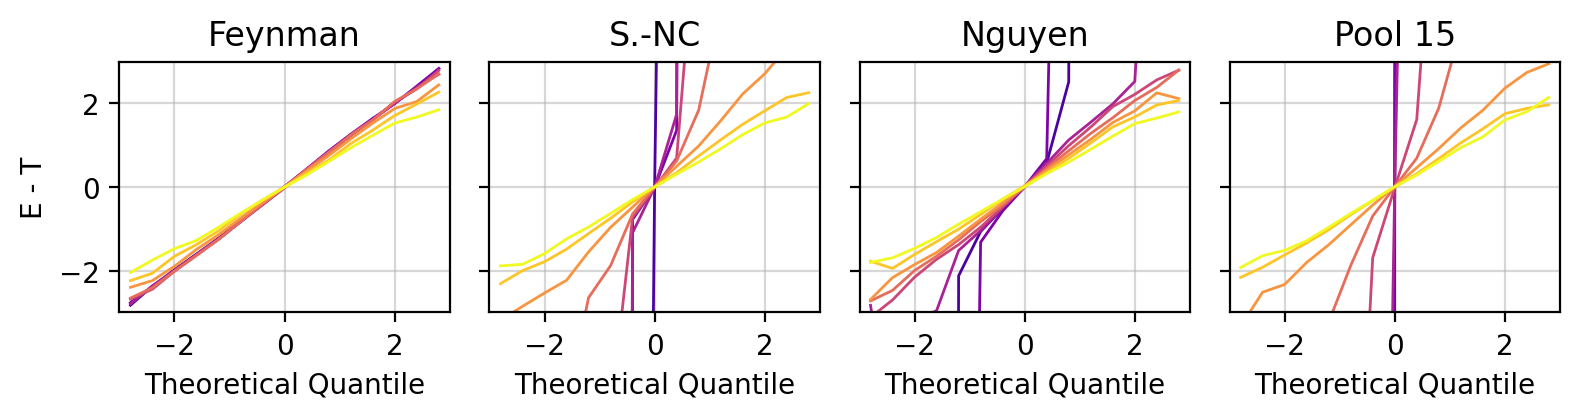

In [29]:
# model_selection = ['analysis_noise/v6.0_1e-2-noise', 'analysis_noise/v6.0_5e-1-noise', 'analysis_noise/v6.0_1e-1-noise']
model_selection = list(results.keys())
results_selection = {k: results[k] for k in model_selection}

COLS = 4
ROWS = 1 # len(model_selection)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2, ROWS * 2.2), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(results_selection.items()):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[j]
        model_index_in_results = list(results.keys()).index(model)
        color = plt.get_cmap('plasma')(model_index_in_results / (len(results) - 1))

        statistics = all_statistics[(model, test_set)]
        statistics_lower = all_statistics_lower[(model, test_set)]
        statistics_upper = all_statistics_upper[(model, test_set)]
        theoretical_quantiles_list = all_theoretical_quantiles_list[(model, test_set)]
        empirical_quantiles_list = all_empirical_quantiles_list[(model, test_set)]

        # ax.hist2d(theoretical_quantiles_list, empirical_quantiles_list - theoretical_quantiles_list, bins=np.linspace(-lim, lim, 32), rasterized=True)

        # ax.axhline(0, color='w', lw=0.5)
        ax.plot((bins[1:] + bins[:-1]) / 2, statistics['median'], color=color, linewidth=1)
        # ax.fill_between((bins[1:] + bins[:-1]) / 2, statistics['p25'], statistics['p75'], color=color, alpha=0.1)
        # ax.fill_between((bins[1:] + bins[:-1]) / 2, statistics['p5'], statistics['p95'], color=color, alpha=0.1)
        # ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p25'], color=color, linestyle='--', linewidth=0.5)
        # ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p75'], color=color, linestyle='--', linewidth=0.5)
        # ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p5'], color=color, linestyle=':', linewidth=0.5)
        # ax.plot((bins[1:] + bins[:-1]) / 2, statistics['p95'], color=color, linestyle=':', linewidth=0.5)

        ax.grid(alpha=0.5)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        ax.set_xlabel('Theoretical Quantile')

        if j == 0:
            ax.set_ylabel('E - T')
            ax.annotate(f'$\\eta = {configs[model]["noise_level"]}$', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8, color='w')

        # if i - k * 4 == j:
        #     ax.legend(loc='lower right', ncol=1)

fig.tight_layout()

In [30]:
def sci_to_latex(num):
    if num == 0:
        return '0'
    if num == 1:
        return '1'
    # If multiple of 10 or 1/10, return as 10^x
    if np.log10(abs(num)) % 1 == 0:
        return f"10^{{{np.ceil(np.log10(abs(num))).astype(int):+}}}"
    else:
        s = f"{num:.0e}"
        return s.replace('e', r'\times 10^{').replace('{0', '{').replace('{-0', '{-')  + '}'

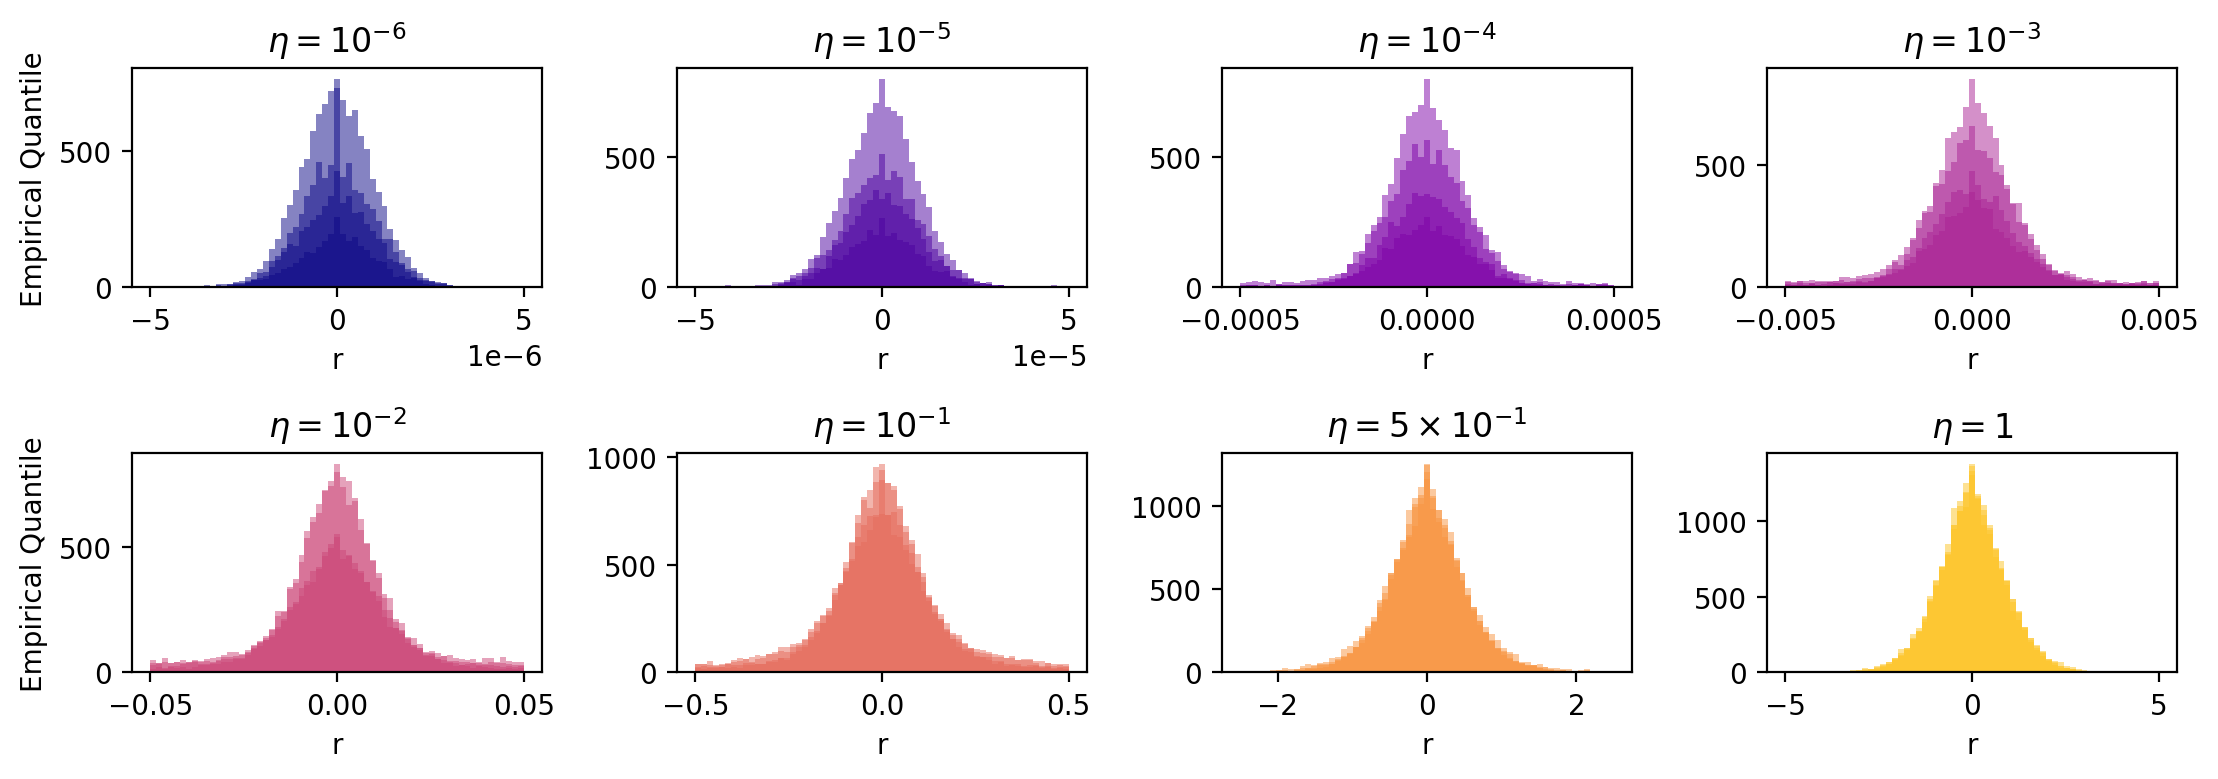

In [31]:
COLS = 4
ROWS = 2

# Deviation curves

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.8, ROWS * 2), dpi=200)

for i, (model, model_results) in enumerate(list(results.items())[1:]):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes.flat[i]
        color = plt.get_cmap('plasma')(i / (len(results) - 1))
        
        eta = configs[model]['noise_level']
        bins = np.linspace(-eta * 5, eta * 5, 64)

        ax.hist(np.concatenate(test_set_results['data']['residuals_scaled']), bins=bins, color=color, alpha=0.5)
        # theoretical_quantiles, empirical_quantiles = get_quantiles(np.concatenate(test_set_results['data']['residuals_scaled']))
        # ax.plot(theoretical_quantiles, empirical_quantiles, color=color, label=("$\\eta = " + sci_to_latex(configs[model]['noise_level']) + "$"))
        # ax.grid(alpha=0.5)
        # ax.set_ylim(-5, 5)

        ax.set_title(("$\\eta = " + sci_to_latex(configs[model]['noise_level']) + "$"))

        ax.set_xlabel('r')

        if i % COLS == 0:
            ax.set_ylabel('Empirical Quantile')

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_hists.svg'))

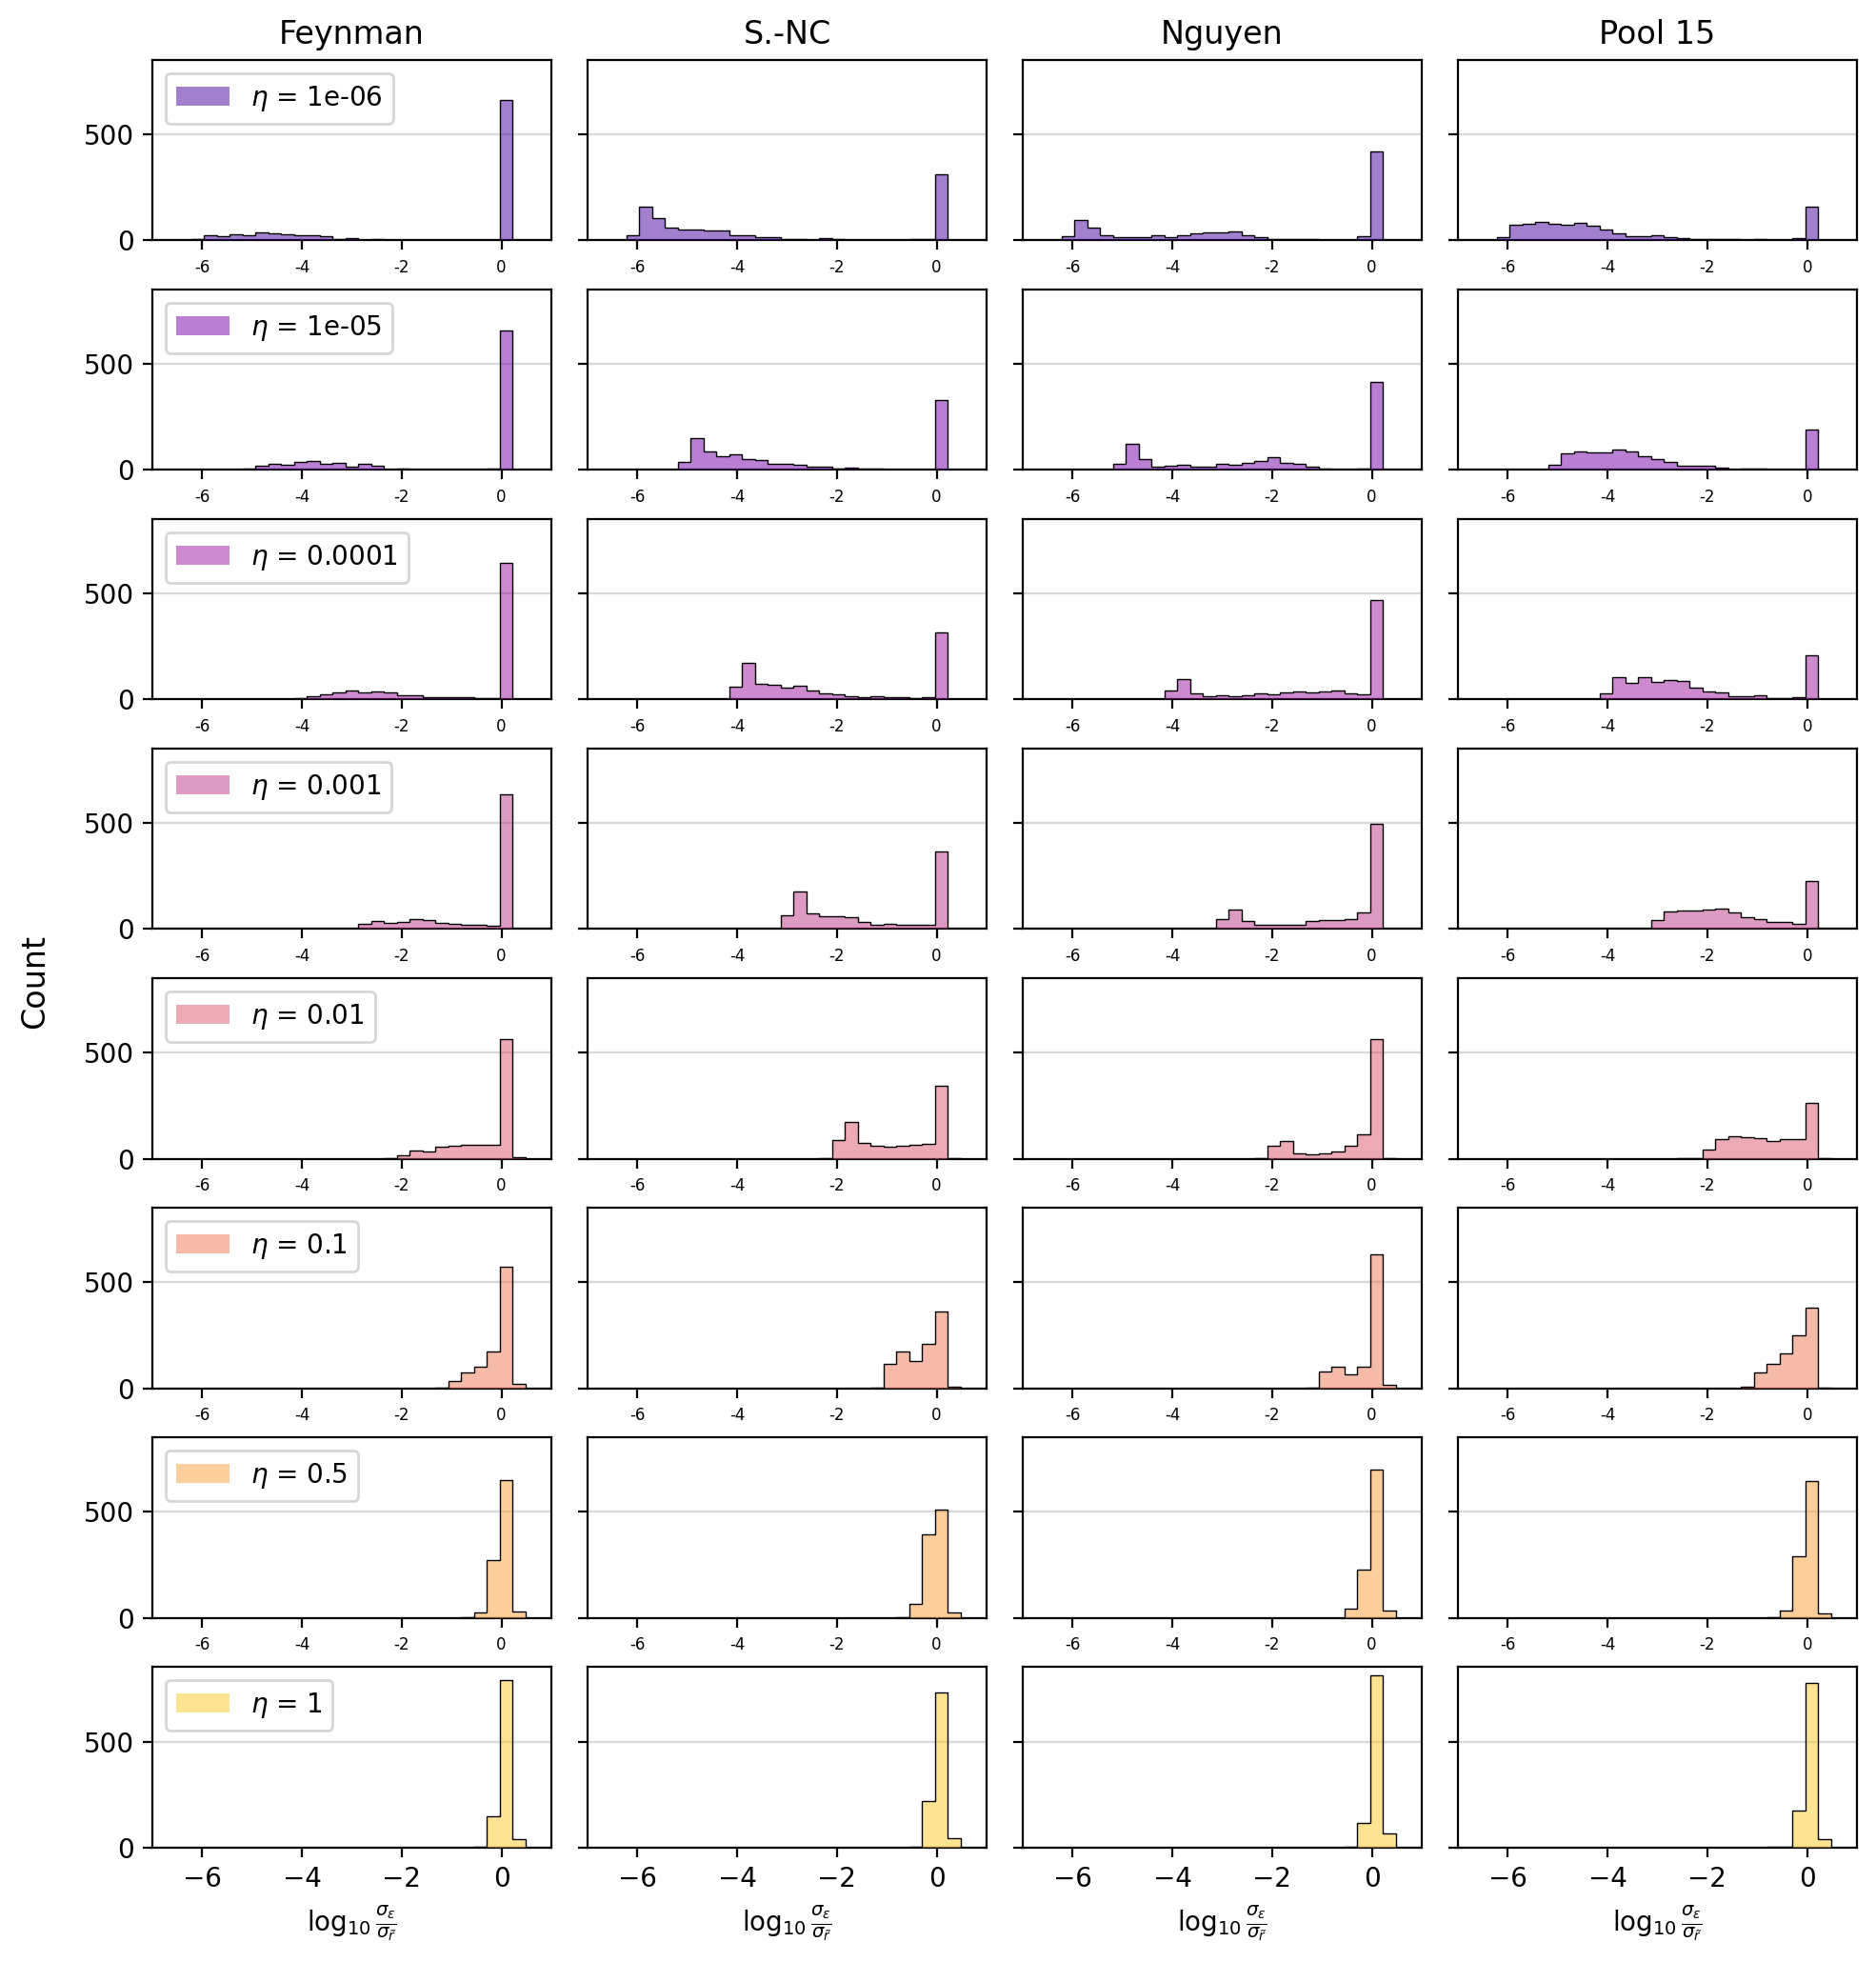

In [32]:
COLS = 4
ROWS = len(results)

xlim = (-7, 1)
bins = 32

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.3), dpi=200, sharey=True)

for i, (model, model_results) in enumerate(list(results.items())):
    for j, (test_set, test_set_results) in enumerate(list(model_results.items())):

        ax = axes[i, j]
        color = plt.get_cmap('plasma')((i + 1) / len(results))

        valid_residuals_std = test_set_results['data']['residuals_std']
        valid_residuals_std_mask = np.isfinite(valid_residuals_std) & (valid_residuals_std > 0)

        valid_noise_std = test_set_results['data']['noise_std']
        valid_noise_std_mask =np.isfinite(valid_noise_std) & (valid_noise_std > 0)

        both_valid_mask = valid_residuals_std_mask & valid_noise_std_mask

        valid_residuals_std = valid_residuals_std[both_valid_mask]
        valid_noise_std = valid_noise_std[both_valid_mask]

        ax.hist(np.log10(valid_noise_std) - np.log10(valid_residuals_std) , bins=np.linspace(*xlim, bins), color=color, alpha=0.5, label=f"$\\eta$ = {configs[model]['noise_level']}", zorder=3, rasterized=True)
        ax.hist(np.log10(valid_noise_std) - np.log10(valid_residuals_std), bins=np.linspace(*xlim, bins), color='k', histtype='step', zorder=4, linewidth=0.5)
        ax.set_xlim(xlim)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 2:
            ax.set_xlabel('$\\log_{10} \\frac{\\sigma_{\\epsilon}}{ \\sigma_{\\tilde r}}$')
            ax.set_xticks(np.arange(-8, 2, 2))
        else:
            ax.set_xticks(np.arange(-8, 2, 2))
            ax.set_xticklabels(np.arange(-8, 2, 2), fontsize=6)

        ax.set_xlim(xlim)

        if j == 0:
            # ax.set_ylabel('Count')
            ax.legend(loc='upper left')
            # ax.set_yticks([0, 50, 100, 150, 200])

        ax.grid(alpha=0.5, zorder=0, axis='y')

fig.tight_layout(h_pad=0.5)
fig.supylabel('Count')
fig.subplots_adjust(left=0.09)

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_residuals_std_diff_histogram.svg'))

/tmp/ipykernel_1002/1561777876.py:27: RuntimeWarning: invalid value encountered in divide
  valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
/tmp/ipykernel_1002/1561777876.py:27: RuntimeWarning: divide by zero encountered in divide
  valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
/tmp/ipykernel_1002/1561777876.py:50: RuntimeWarning: invalid value encountered in divide
  valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
/tmp/ipykernel_1002/1561777876.py:50: RuntimeWarning: divide by zero encountered in divide
  valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']


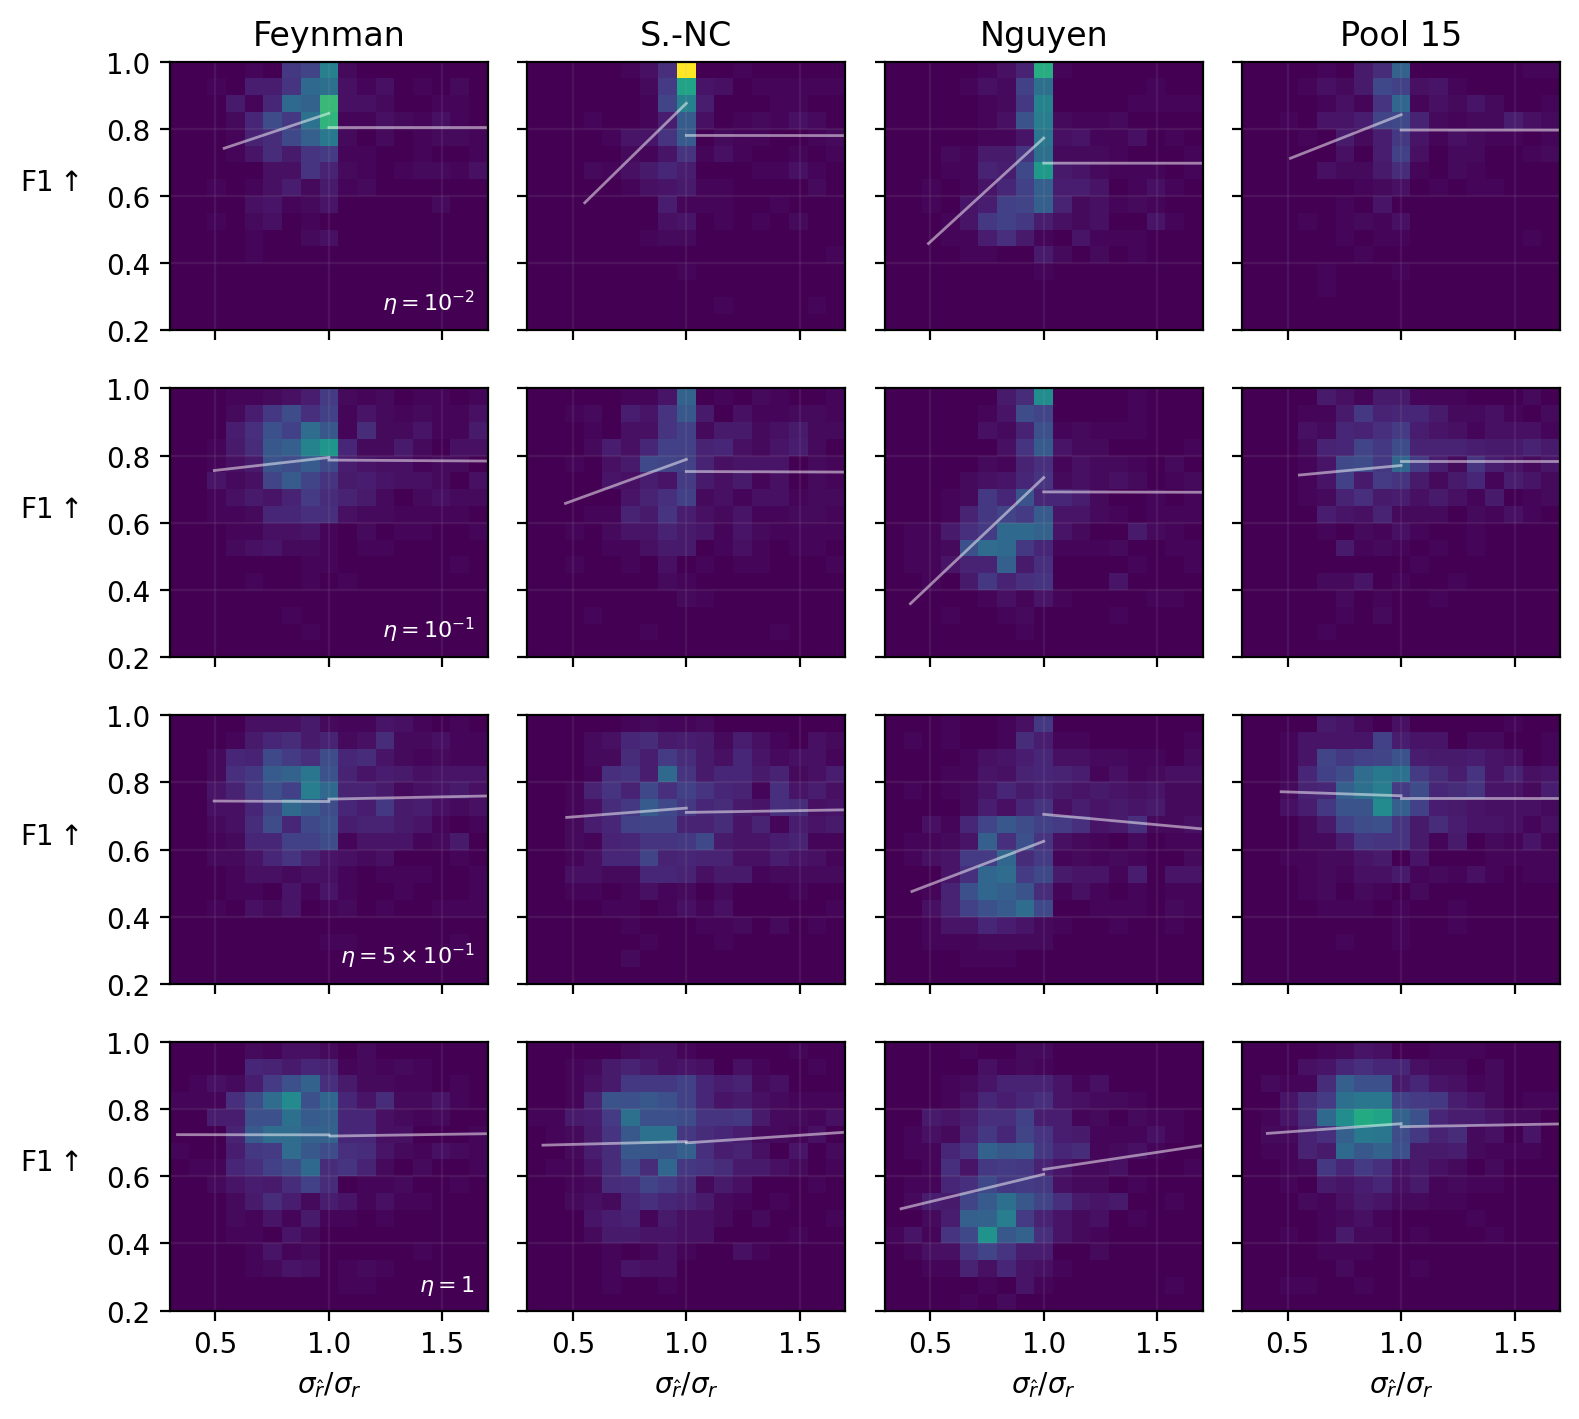

In [33]:
ROWS = len(results) - 5
COLS = 4

# ylim = (0, 58)
# ylim = (-2.5, -1)
ylim = (0.2, 1)
xbins = 18
ybins = 17

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2, ROWS * 1.8), dpi=200, sharex=True, sharey=True)

vmin = np.inf
vmax = -np.inf

for j, (model, model_results) in enumerate(list(results.items())[5:]):
    for i, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[j, i]
        color = plt.get_cmap('plasma')(i / len(results))
        
        eta = configs[model]['noise_level']

        xlim = (0.3, 1.7)

        valid_data_y = test_set_results['data']['f1_score_best_beam']
        valid_data_y_mask = np.isfinite(valid_data_y) & (valid_data_y > 0)

        valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
        valid_data_x_mask = np.isfinite(valid_data_x) & (valid_data_x > 0)

        both_valid_mask = valid_data_x_mask & valid_data_y_mask

        values, xedges, yedges = np.histogram2d(valid_data_x[both_valid_mask], valid_data_y[both_valid_mask], bins=(np.linspace(*xlim, xbins), np.linspace(*ylim, ybins)))

        vmin = min(vmin, np.min(values))
        vmax = max(vmax, np.max(values))


for j, (model, model_results) in enumerate(list(results.items())[5:]):
    for i, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[j, i]
        color = plt.get_cmap('plasma')(i / len(results))
        
        eta = configs[model]['noise_level']

        xlim = (0.3, 1.7)

        valid_data_y = test_set_results['data']['f1_score_best_beam']
        valid_data_y_mask = np.isfinite(valid_data_y) & (valid_data_y > 0)

        valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
        valid_data_x_mask = np.isfinite(valid_data_x) & (valid_data_x > 0)

        both_valid_mask = valid_data_x_mask & valid_data_y_mask

        ax.hist2d(valid_data_x[both_valid_mask], valid_data_y[both_valid_mask], bins=(np.linspace(*xlim, xbins), np.linspace(*ylim, ybins)), cmap='viridis', rasterized=True, vmin=vmin, vmax=vmax)

        # In the regions from -0.5 to 0 and 0 to 0.5, fit a line to each half of the data
        x = valid_data_x[both_valid_mask]
        y = valid_data_y[both_valid_mask]

        x1 = x[x < 1]
        y1 = y[x < 1]

        x2 = x[x > 1]
        y2 = y[x > 1]

        if len(x1) > 0:
            m1, b1 = np.polyfit(x1, y1, 1)
            x1_plot = np.array([np.min(x1), np.max(x1)])
            ax.plot(x1_plot, m1 * x1_plot + b1, color='w', linewidth=1, alpha=0.5)
 
        if len(x2) > 0:
            m2, b2 = np.polyfit(x2, y2, 1)
            x2_plot = np.array([np.min(x2), np.max(x2)])
            ax.plot(x2_plot, m2 * x2_plot + b2, color='w', linewidth=1, alpha=0.5)

        if i == 0:
            ax.set_ylabel('F1$\\uparrow$', rotation=0, labelpad=10, ha='right')
            ax.annotate(f"$\\eta = {sci_to_latex(eta)}$", xy=(0.96, 0.05), xycoords='axes fraction', fontsize=8, ha='right', va='bottom', color='w')

        if j == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        if j == ROWS - 1:
            ax.set_xlabel('$\\sigma_{\\hat r} / \\sigma_{r}$')

        ax.grid(alpha=0.1)

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_identifiability.svg'))

In [34]:
from scipy.optimize import curve_fit

In [35]:
parameters = {}

for j, (model, model_results) in enumerate(list(results.items())[1:]):
    parameters[model] = {}
    for i, (test_set, test_set_results) in enumerate(model_results.items()):
        color = plt.get_cmap('plasma')(i / len(results))
        
        eta = configs[model]['noise_level']

        valid_data_y = test_set_results['data']['f1_score_best_beam']
        valid_data_y_mask = np.isfinite(valid_data_y) & (valid_data_y > 0)

        valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
        valid_data_x_mask = np.isfinite(valid_data_x) & (valid_data_x > 0)

        both_valid_mask = valid_data_x_mask & valid_data_y_mask

        # In the regions from -0.5 to 0 and 0 to 0.5, fit a line to each half of the data
        x = valid_data_x[both_valid_mask]
        y = valid_data_y[both_valid_mask]

        x1 = x[x < 1]
        y1 = y[x < 1]

        x2 = x[x > 1]
        y2 = y[x > 1]

        if len(x1) > 0:
            popt1, pcov1 = curve_fit(lambda x, m, b: m * x + b, x1, y1)
            parameters[model][test_set + '_1'] = (popt1, pcov1)

        if len(x2) > 0:
            popt2, pcov2 = curve_fit(lambda x, m, b: m * x + b, x2, y2)
            parameters[model][test_set + '_2'] = point2 = (popt2, pcov2)


/tmp/ipykernel_1002/1362754655.py:13: RuntimeWarning: divide by zero encountered in divide
  valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']
/tmp/ipykernel_1002/1362754655.py:13: RuntimeWarning: invalid value encountered in divide
  valid_data_x = test_set_results['data']['residuals_std'] / test_set_results['data']['noise_std']


In [36]:
params_df = pd.DataFrame({model: {k: v[0][0] for k, v in params.items() if k.endswith('_1')} for model, params in parameters.items()})
params_err_df = pd.DataFrame({model: {k: v[1][0, 0] for k, v in params.items() if k.endswith('_1')} for model, params in parameters.items()})

In [37]:
params_df.round(2).astype(str).T + " ± " + params_err_df.round(2).astype(str).T

,feynman_1,soose_nc_1,nguyen_1,pool_15_1
analysis_noise/v6.0_1e-6-noise,0.1 ± 0.0,0.29 ± 0.02,0.34 ± 0.02,-0.08 ± 0.04
analysis_noise/v6.0_1e-5-noise,0.03 ± 0.01,0.3 ± 0.02,0.09 ± 0.02,0.44 ± 0.04
analysis_noise/v6.0_1e-4-noise,0.05 ± 0.01,0.3 ± 0.02,0.0 ± 0.02,0.51 ± 0.02
analysis_noise/v6.0_1e-3-noise,0.28 ± 0.0,0.31 ± 0.01,0.36 ± 0.01,0.2 ± 0.01
analysis_noise/v6.0_1e-2-noise,0.23 ± 0.0,0.66 ± 0.01,0.62 ± 0.0,0.27 ± 0.01
analysis_noise/v6.0_1e-1-noise,0.08 ± 0.0,0.25 ± 0.01,0.64 ± 0.0,0.06 ± 0.0
analysis_noise/v6.0_5e-1-noise,-0.0 ± 0.0,0.05 ± 0.0,0.26 ± 0.0,-0.02 ± 0.0
analysis_noise/v6.0_1-noise,-0.0 ± 0.0,0.02 ± 0.0,0.16 ± 0.0,0.05 ± 0.0


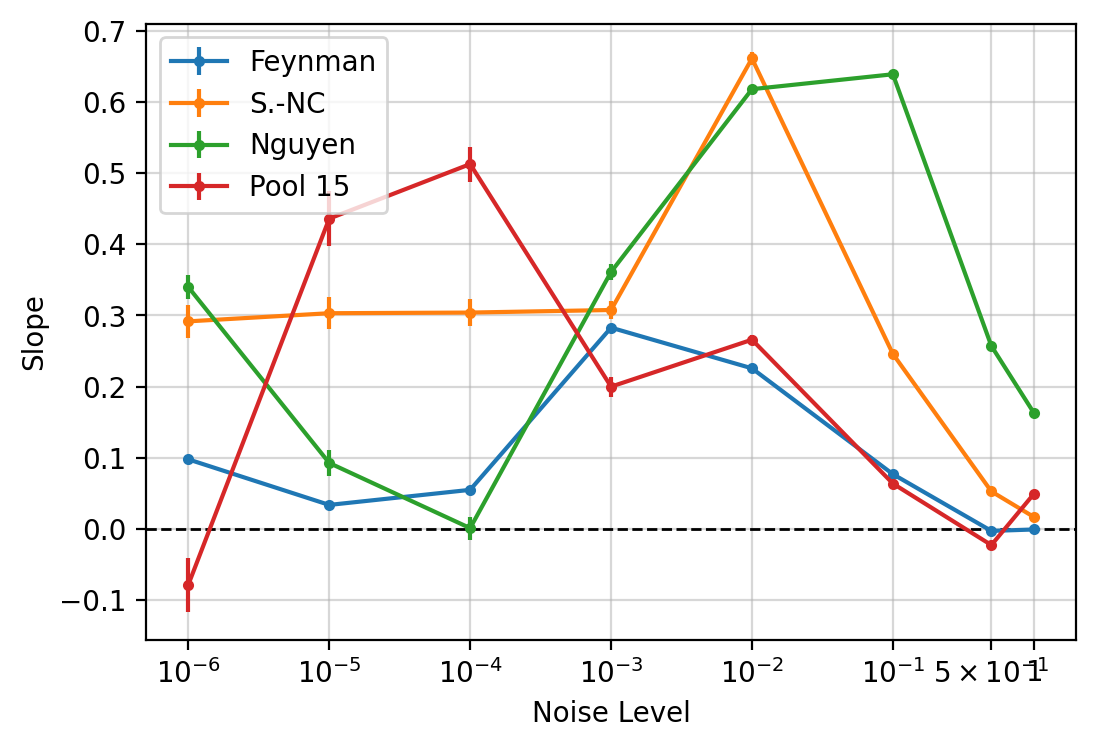

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

noise_levels = [configs[model]['noise_level'] for model in results.keys()][1:]

for i, test_set in enumerate(params_df.T.columns):
    ax.errorbar(np.log10(noise_levels), params_df.loc[test_set, :], params_err_df.loc[test_set, :], fmt='.-', label=TEST_SET_TITLES[test_set[:-2]])

ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.set_ylabel('Slope')
ax.set_xlabel('Noise Level')
ax.legend()
ax.grid(alpha=0.5)
ax.set_xticks(np.log10(noise_levels))
ax.set_xticklabels([f'${sci_to_latex(eta)}$' for eta in noise_levels]);

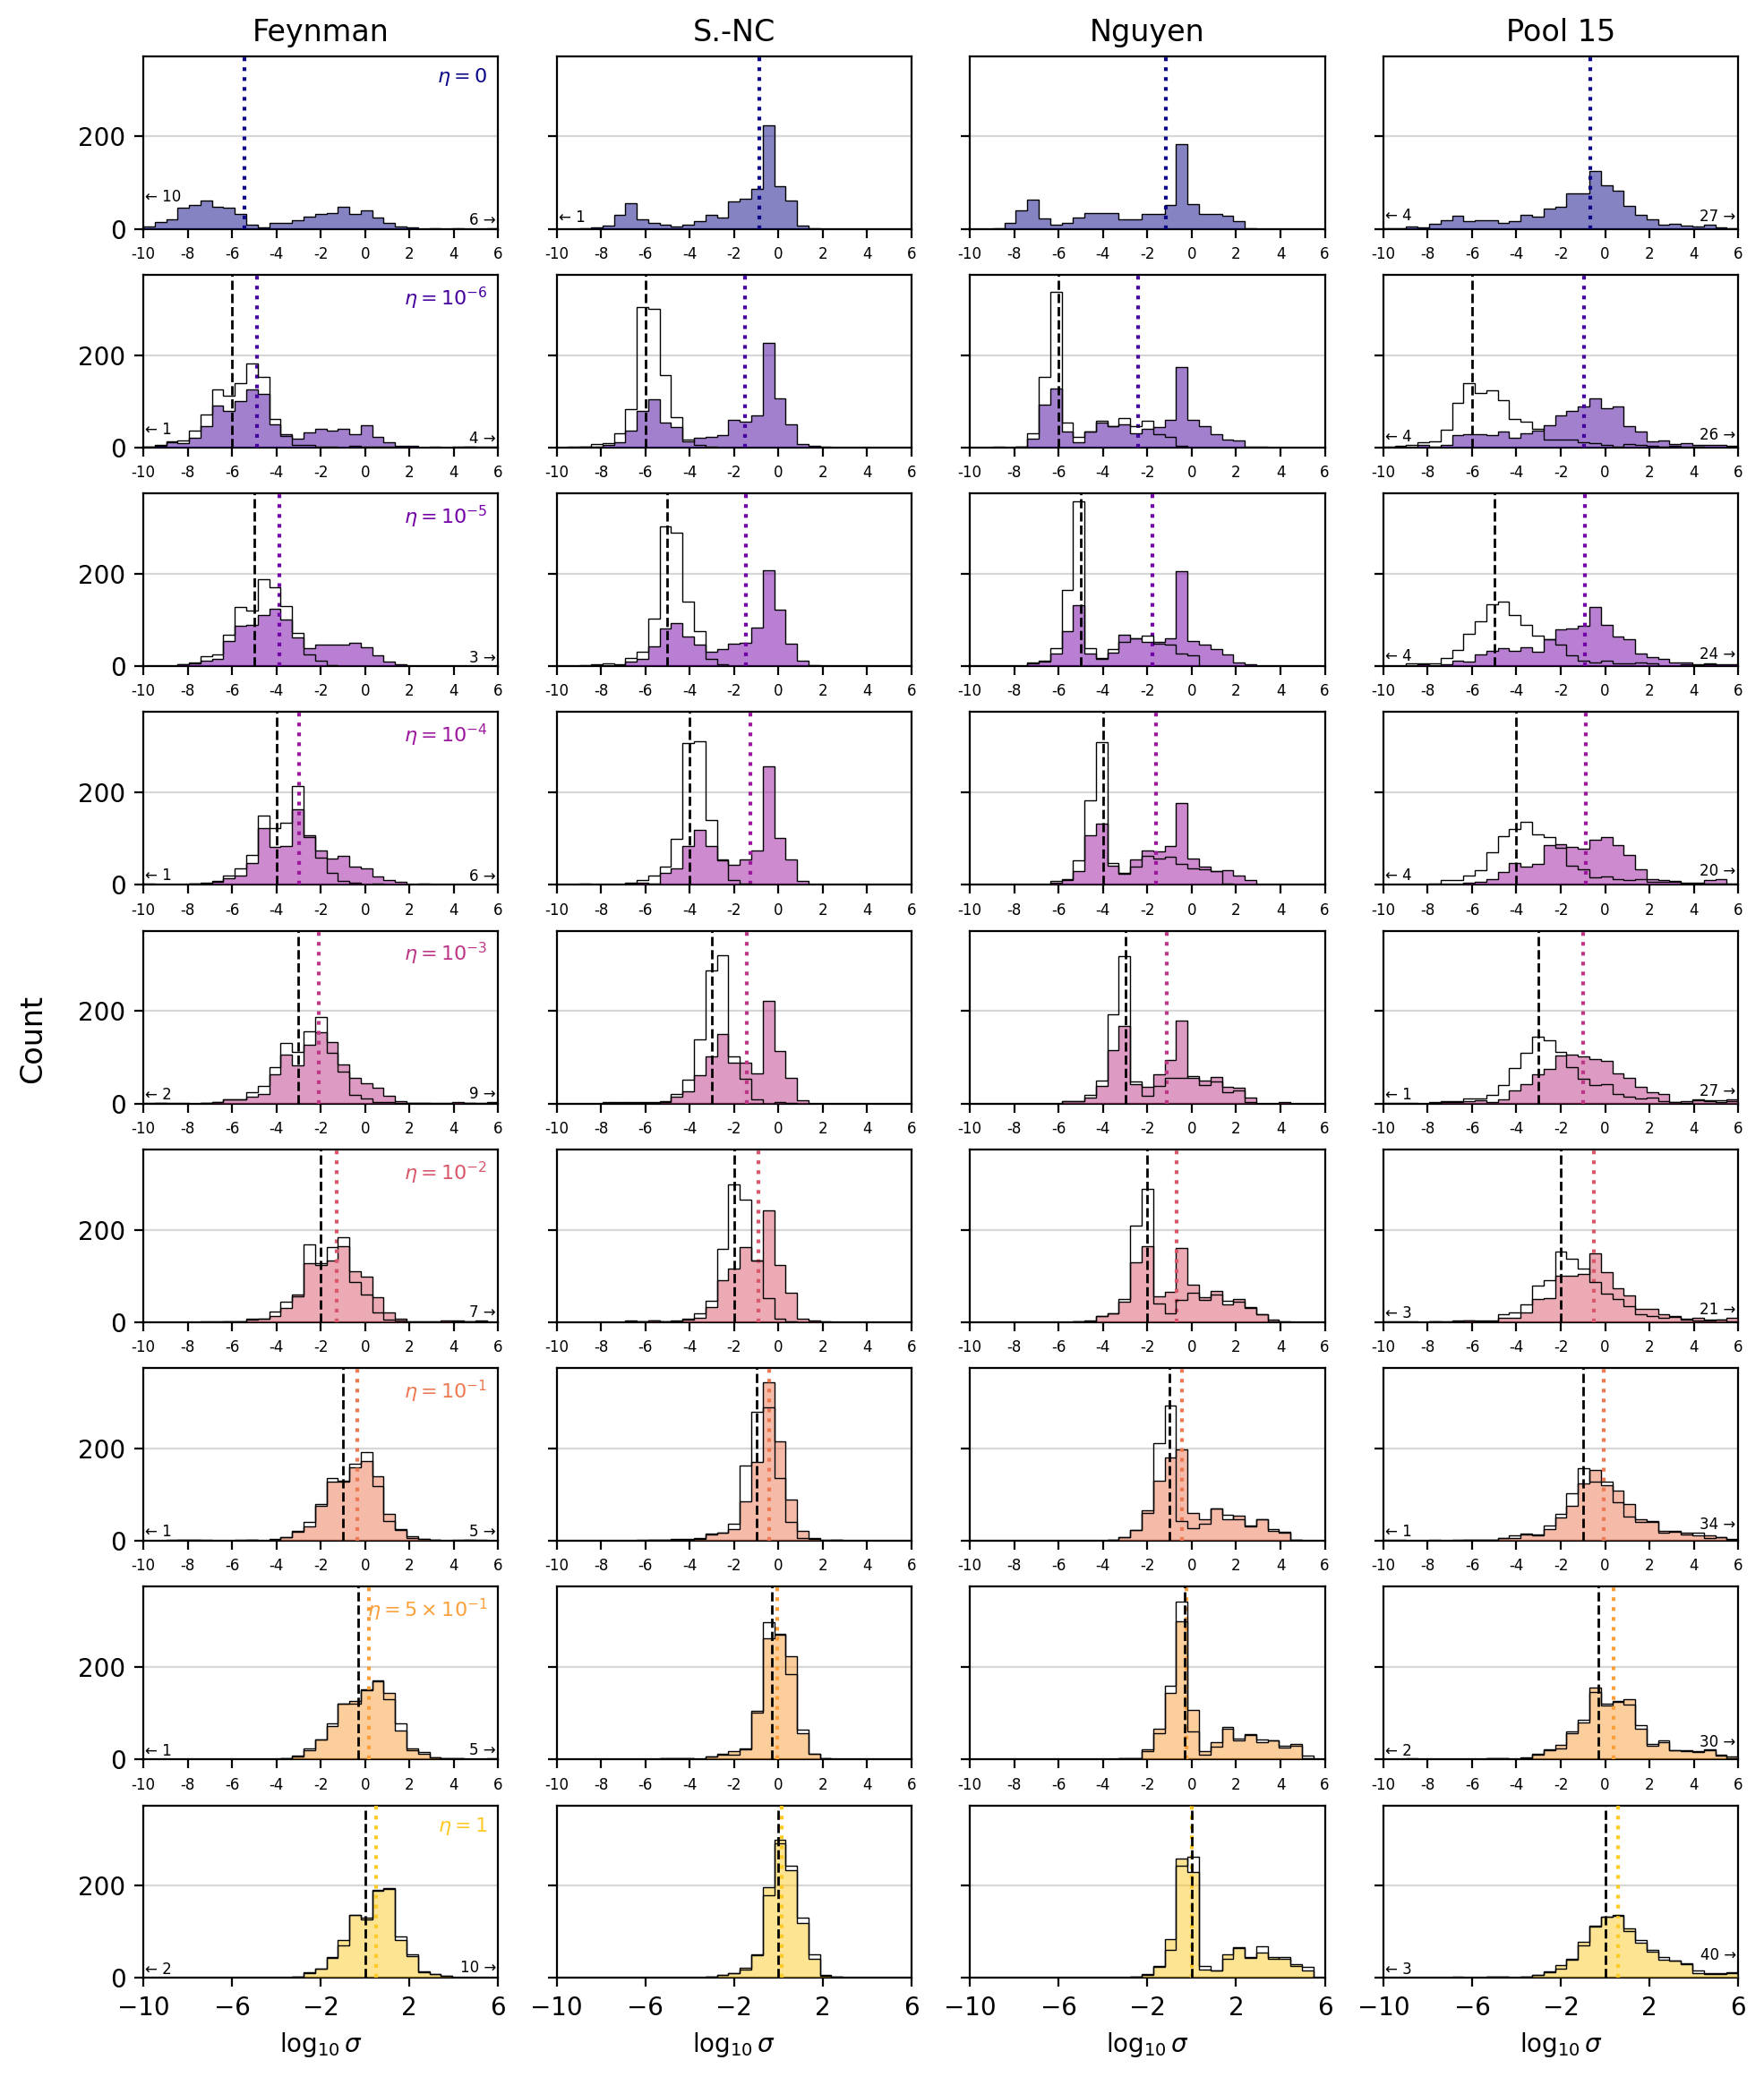

In [39]:
COLS = 4
ROWS = len(results)

xlim = (-10, 6)
bins = 32

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.3), dpi=200, sharey=True)

for i, (model, model_results) in enumerate(results.items()):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        color = plt.get_cmap('plasma')(i / len(results))
        valid_data = test_set_results['data']['residuals_std']
        valid_data = valid_data[np.isfinite(valid_data) & (valid_data > 0)]
        ax.hist(np.log10(valid_data), bins=np.linspace(*xlim, bins), color=color, alpha=0.5, zorder=3, rasterized=True);
        ax.hist(np.log10(valid_data), bins=np.linspace(*xlim, bins), color='k', histtype='step', zorder=4, linewidth=0.5);

        if configs[model]['noise_level'] > 0:
            ax.axvline(np.log10(configs[model]['noise_level']), color='k', linestyle='--', zorder=5, linewidth=1)

        ax.axvline(np.log10(np.median(valid_data)), color=color, linestyle=':', zorder=4)

        values, edges = np.histogram(np.log10(valid_data), bins=np.linspace(*xlim, bins))
        
        valid_gt_data = test_set_results['data']['noise_std']
        valid_gt_data = valid_gt_data[np.isfinite(valid_gt_data) & (valid_gt_data > 0)]
        ax.hist(np.log10(valid_gt_data), bins=np.linspace(*xlim, bins), color='k', histtype='step', zorder=4, linewidth=0.5);

        # Annotate on the left and right edges of the axis the number less than and greater than the xlim
        if np.sum(valid_data < 10**xlim[0]) > 0:
            ax.text(xlim[0] + 0.1, np.max(values[:5]), f"← {np.sum(valid_data < 10**xlim[0])}", ha='left', va='bottom', fontsize=6)
        if np.sum(valid_data > 10**xlim[1]) > 0:
            ax.text(xlim[1] - 0.1, np.max(values[-5:]), f"{np.sum(valid_data > 10**xlim[1])} →", ha='right', va='bottom', fontsize=6)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('$\\log_{10} \\sigma$')
            ax.set_xticks(np.arange(-10, 8, 4))
        else:
            ax.set_xticks(np.arange(-10, 8, 2))
            ax.set_xticklabels(np.arange(-10, 8, 2), fontsize=6)

        ax.set_xlim(xlim)

        if j == 0:
            # ax.set_ylabel('Count')
            # ax.legend(loc='upper right')
            ax.annotate(f"$\\eta = {sci_to_latex(configs[model]['noise_level'])}$", xy=(0.97, 0.94), xycoords='axes fraction', fontsize=8, ha='right', va='top', color=color)

        ax.grid(alpha=0.5, zorder=0, axis='y')

fig.tight_layout(h_pad=0.5)
fig.supylabel('Count')
fig.subplots_adjust(left=0.09)

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_residuals_std_histogram.svg'))

/tmp/ipykernel_1002/925004002.py:14: RuntimeWarning: divide by zero encountered in log10
  counts, edges = np.histogram(np.log10(test_set_results['data']['residuals_std']), bins=np.linspace(*xlim, bins))
/tmp/ipykernel_1002/925004002.py:15: RuntimeWarning: divide by zero encountered in log10
  counts_background, edges_background = np.histogram(np.log10(results['analysis_noise/v6.0_0.0-noise'][test_set]['data']['residuals_std']), bins=np.linspace(*xlim, bins))


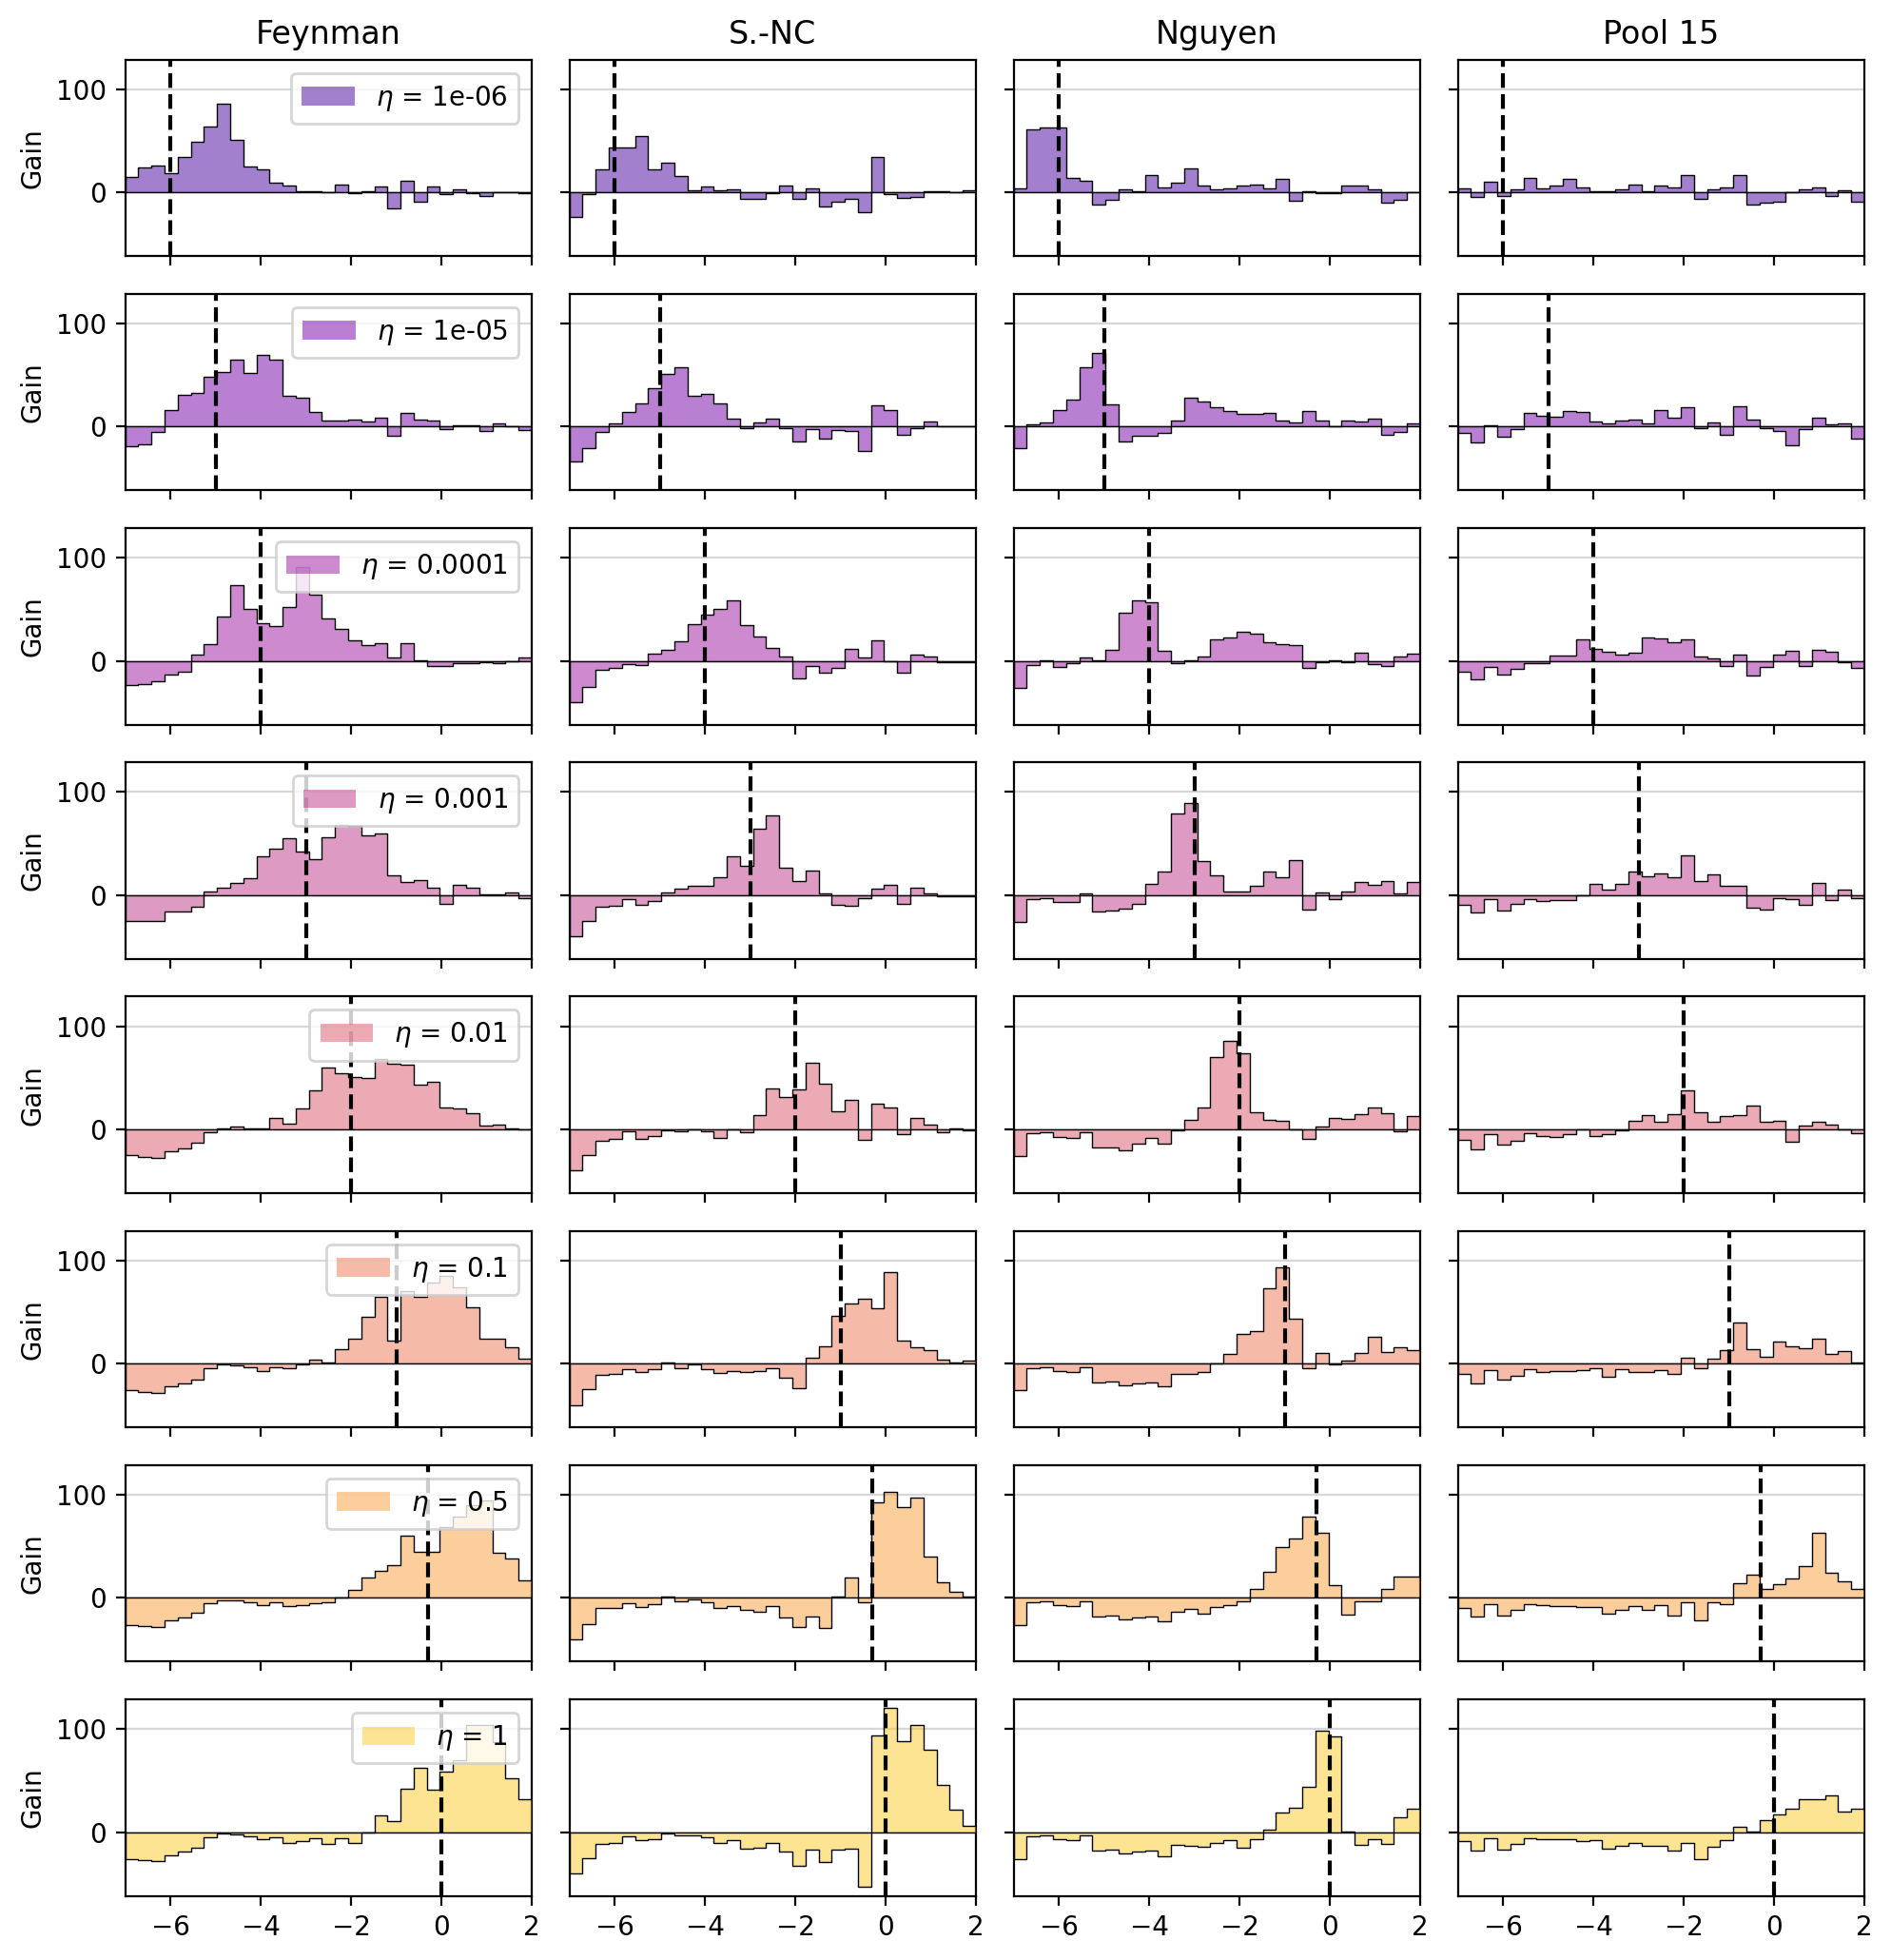

In [40]:
COLS = 4
ROWS = len(results) - 1


xlim = (-7, 2)
bins = 32

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.3), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(list(results.items())[1:]):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        color = plt.get_cmap('plasma')((i + 1) / len(results))
        counts, edges = np.histogram(np.log10(test_set_results['data']['residuals_std']), bins=np.linspace(*xlim, bins))
        counts_background, edges_background = np.histogram(np.log10(results['analysis_noise/v6.0_0.0-noise'][test_set]['data']['residuals_std']), bins=np.linspace(*xlim, bins))

        ax.bar(edges[:-1], counts - counts_background, width=np.diff(edges), color=color, alpha=0.5, label=f"$\\eta$ = {configs[model]['noise_level']}", align='edge', zorder=3, rasterized=True);

        # Outline
        x_list = [edges[0]]
        y_list = [0]

        for ledge, redge, value in zip(edges[:-1], edges[1:], counts - counts_background):
            x_list.extend([ledge, redge])
            y_list.extend([value, value])

        x_list.append(edges[-1])
        y_list.append(0)

        ax.plot(x_list, y_list, color='k', zorder=4, linewidth=0.5)

        ax.axhline(0, color='k', linewidth=0.5, zorder=4)

        # difference_error = np.sqrt(counts + counts_background)
        # centers = (edges[:-1] + edges[1:]) / 2
        # ax.errorbar(centers, counts - counts_background, yerr=difference_error, fmt='.', color=color, zorder=5, markersize=0, elinewidth=1, alpha=0.5)

        ax.set_xlim(xlim)
        ax.axvline(np.log10(configs[model]['noise_level']), color='k', linestyle='--', zorder=4)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('$log_{10}$(std(scaled residuals))')
            ax.set_xticks(np.arange(xlim[0], xlim[1] + 1, 1))

        if j == 0:
            ax.set_ylabel('Gain')
            ax.legend(loc='upper right')

        ax.grid(alpha=0.5, zorder=0, axis='y')

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_residuals_std_gain.svg'))

In [41]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c or 'quantiles' in c or 'residuals' in c or 'noise' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'L_inf_best_beam',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'is_finite',
 'is_overfit',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structural_accuracy_best_beam',
 'sys_time',
 'tree_edit_distance_best_beam',
 'wall_time',
 'y_std'}

In [42]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [43]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'log_fvu': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [44]:
from functools import partial

In [45]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [46]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_noise/v6.0_0.0-noise feynman:  13%|█▎        | 5/39 [00:00<00:03,  9.65it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_noise/v6.0_1-noise pool_15: 100%|██████████| 39/39 [00:03<00:00,  9.75it/s]


In [47]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [48]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-6-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-5-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-4-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-3-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-2-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)"
analysis_noise/v6.0_1e-1-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_5e-1-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [49]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.805 (0.781, 0.831)","0.472 (0.441, 0.502)","0.667 (0.638, 0.699)","0.504 (0.472, 0.534)"
analysis_noise/v6.0_1e-6-noise,"0.816 (0.793, 0.84)","0.492 (0.461, 0.526)","0.634 (0.603, 0.665)","0.508 (0.476, 0.535)"
analysis_noise/v6.0_1e-5-noise,"0.8 (0.775, 0.824)","0.483 (0.453, 0.514)","0.605 (0.575, 0.635)","0.512 (0.479, 0.542)"
analysis_noise/v6.0_1e-4-noise,"0.766 (0.741, 0.791)","0.468 (0.438, 0.502)","0.574 (0.542, 0.602)","0.506 (0.47, 0.538)"
analysis_noise/v6.0_1e-3-noise,"0.632 (0.602, 0.66)","0.456 (0.425, 0.486)","0.529 (0.497, 0.558)","0.507 (0.475, 0.537)"
analysis_noise/v6.0_1e-2-noise,"0.293 (0.268, 0.323)","0.311 (0.282, 0.339)","0.361 (0.331, 0.391)","0.385 (0.354, 0.415)"
analysis_noise/v6.0_1e-1-noise,"0.1 (0.081, 0.118)","0.124 (0.104, 0.146)","0.212 (0.187, 0.236)","0.252 (0.227, 0.28)"
analysis_noise/v6.0_5e-1-noise,"0.042 (0.031, 0.056)","0.047 (0.034, 0.061)","0.098 (0.08, 0.117)","0.111 (0.093, 0.132)"
analysis_noise/v6.0_1-noise,"0.026 (0.016, 0.037)","0.021 (0.012, 0.031)","0.043 (0.031, 0.055)","0.079 (0.063, 0.096)"


In [50]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.944 (0.929, 0.958)","0.681 (0.652, 0.709)","0.82 (0.796, 0.844)","0.785 (0.759, 0.811)"
analysis_noise/v6.0_1e-6-noise,"0.945 (0.93, 0.959)","0.688 (0.659, 0.717)","0.817 (0.792, 0.841)","0.792 (0.764, 0.817)"
analysis_noise/v6.0_1e-5-noise,"0.941 (0.926, 0.955)","0.695 (0.666, 0.724)","0.789 (0.763, 0.813)","0.8 (0.776, 0.826)"
analysis_noise/v6.0_1e-4-noise,"0.951 (0.938, 0.964)","0.684 (0.655, 0.712)","0.827 (0.803, 0.851)","0.77 (0.744, 0.797)"
analysis_noise/v6.0_1e-3-noise,"0.934 (0.917, 0.948)","0.669 (0.64, 0.698)","0.819 (0.795, 0.843)","0.791 (0.766, 0.813)"
analysis_noise/v6.0_1e-2-noise,"0.919 (0.901, 0.936)","0.668 (0.637, 0.697)","0.829 (0.806, 0.852)","0.767 (0.741, 0.794)"
analysis_noise/v6.0_1e-1-noise,"0.812 (0.787, 0.834)","0.607 (0.579, 0.639)","0.762 (0.735, 0.787)","0.683 (0.653, 0.711)"
analysis_noise/v6.0_5e-1-noise,"0.045 (0.033, 0.058)","0.022 (0.013, 0.031)","0.017 (0.009, 0.025)","0.032 (0.021, 0.043)"
analysis_noise/v6.0_1-noise,"0.02 (0.011, 0.029)","0.002 (0.0, 0.005)","0.002 (0.0, 0.005)","0.017 (0.01, 0.025)"


In [51]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.715 (0.687, 0.741)","0.332 (0.3, 0.361)","0.539 (0.506, 0.568)","0.239 (0.212, 0.266)"
analysis_noise/v6.0_1e-6-noise,"0.707 (0.679, 0.736)","0.361 (0.332, 0.389)","0.514 (0.48, 0.545)","0.227 (0.202, 0.256)"
analysis_noise/v6.0_1e-5-noise,"0.692 (0.662, 0.721)","0.352 (0.32, 0.382)","0.483 (0.452, 0.514)","0.218 (0.193, 0.243)"
analysis_noise/v6.0_1e-4-noise,"0.69 (0.662, 0.718)","0.335 (0.305, 0.361)","0.517 (0.484, 0.549)","0.235 (0.209, 0.261)"
analysis_noise/v6.0_1e-3-noise,"0.028 (0.018, 0.039)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.006 (0.002, 0.011)"
analysis_noise/v6.0_1e-2-noise,"0.024 (0.015, 0.034)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.013 (0.007, 0.02)"
analysis_noise/v6.0_1e-1-noise,"0.022 (0.013, 0.032)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.005 (0.001, 0.01)"
analysis_noise/v6.0_5e-1-noise,"0.021 (0.013, 0.03)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.007 (0.003, 0.013)"
analysis_noise/v6.0_1-noise,"0.019 (0.011, 0.027)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.008 (0.004, 0.014)"


#### Numeric Error

In [52]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.205 (0.111, 0.286)","0.695 (0.62, 0.796)","0.565 (0.524, 0.609)","0.589 (0.518, 0.671)"
analysis_noise/v6.0_1e-6-noise,"0.259 (0.13, 0.365)","0.654 (0.607, 0.707)","0.593 (0.546, 0.653)","0.599 (0.532, 0.721)"
analysis_noise/v6.0_1e-5-noise,"0.201 (0.169, 0.32)","0.717 (0.653, 0.768)","0.636 (0.563, 0.712)","0.587 (0.518, 0.65)"
analysis_noise/v6.0_1e-4-noise,"0.22 (0.107, 0.302)","0.672 (0.628, 0.734)","0.625 (0.583, 0.706)","0.593 (0.543, 0.708)"
analysis_noise/v6.0_1e-3-noise,"0.194 (0.116, 0.276)","0.704 (0.63, 0.751)","0.602 (0.532, 0.664)","0.684 (0.562, 0.83)"
analysis_noise/v6.0_1e-2-noise,"0.319 (0.255, 0.432)","0.711 (0.652, 0.742)","0.592 (0.551, 0.667)","0.587 (0.493, 0.712)"
analysis_noise/v6.0_1e-1-noise,"0.427 (0.379, 0.573)","0.737 (0.674, 0.797)","0.59 (0.555, 0.633)","0.671 (0.591, 0.751)"
analysis_noise/v6.0_5e-1-noise,"0.761 (0.706, 0.846)","0.904 (0.837, 0.996)","0.812 (0.742, 0.877)","0.861 (0.719, 0.907)"
analysis_noise/v6.0_1-noise,"0.994 (0.917, 1.031)","1.005 (0.965, 1.059)","0.897 (0.853, 0.95)","0.995 (0.914, 1.089)"


In [53]:
m = 'is_overfit'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)"
analysis_noise/v6.0_1e-6-noise,"0.549 (0.516, 0.579)","0.205 (0.182, 0.23)","0.294 (0.269, 0.323)","0.119 (0.1, 0.14)"
analysis_noise/v6.0_1e-5-noise,"0.557 (0.526, 0.587)","0.251 (0.224, 0.28)","0.346 (0.319, 0.375)","0.152 (0.13, 0.174)"
analysis_noise/v6.0_1e-4-noise,"0.544 (0.512, 0.575)","0.256 (0.229, 0.285)","0.39 (0.361, 0.419)","0.178 (0.157, 0.204)"
analysis_noise/v6.0_1e-3-noise,"0.58 (0.548, 0.61)","0.29 (0.263, 0.322)","0.407 (0.376, 0.441)","0.199 (0.175, 0.223)"
analysis_noise/v6.0_1e-2-noise,"0.516 (0.486, 0.546)","0.273 (0.244, 0.301)","0.494 (0.464, 0.527)","0.243 (0.215, 0.269)"
analysis_noise/v6.0_1e-1-noise,"0.534 (0.502, 0.564)","0.303 (0.276, 0.331)","0.582 (0.553, 0.611)","0.334 (0.305, 0.363)"
analysis_noise/v6.0_5e-1-noise,"0.611 (0.581, 0.639)","0.466 (0.436, 0.497)","0.668 (0.638, 0.696)","0.588 (0.557, 0.618)"
analysis_noise/v6.0_1-noise,"0.763 (0.734, 0.788)","0.694 (0.666, 0.722)","0.813 (0.788, 0.835)","0.742 (0.713, 0.767)"


#### Time

In [54]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"1.769 (1.739, 1.812)","1.721 (1.702, 1.734)","1.657 (1.639, 1.684)","1.827 (1.78, 1.919)"
analysis_noise/v6.0_1e-6-noise,"2.988 (2.676, 3.16)","2.059 (1.933, 2.144)","1.727 (1.702, 1.771)","1.839 (1.795, 1.915)"
analysis_noise/v6.0_1e-5-noise,"1.724 (1.709, 1.757)","1.713 (1.701, 1.738)","1.701 (1.689, 1.726)","1.903 (1.873, 1.93)"
analysis_noise/v6.0_1e-4-noise,"1.746 (1.708, 1.774)","1.492 (1.472, 1.511)","1.754 (1.736, 1.778)","1.742 (1.728, 1.759)"
analysis_noise/v6.0_1e-3-noise,"2.79 (2.536, 3.032)","1.65 (1.641, 1.659)","1.738 (1.706, 1.768)","1.86 (1.821, 1.941)"
analysis_noise/v6.0_1e-2-noise,"1.775 (1.75, 1.794)","1.717 (1.701, 1.741)","1.791 (1.752, 1.824)","1.809 (1.777, 1.84)"
analysis_noise/v6.0_1e-1-noise,"1.838 (1.813, 1.89)","1.756 (1.734, 1.778)","1.892 (1.847, 1.936)","1.877 (1.838, 1.915)"
analysis_noise/v6.0_5e-1-noise,"1.856 (1.823, 1.918)","1.789 (1.769, 1.812)","1.828 (1.798, 1.871)","1.851 (1.82, 1.895)"
analysis_noise/v6.0_1-noise,"1.721 (1.702, 1.74)","1.713 (1.69, 1.734)","1.934 (1.895, 1.996)","2.133 (2.045, 2.288)"


In [55]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"1.769 (1.738, 1.819)","1.721 (1.703, 1.734)","1.657 (1.641, 1.682)","1.827 (1.779, 1.906)"
analysis_noise/v6.0_1e-6-noise,"2.988 (2.689, 3.155)","2.058 (1.935, 2.138)","1.731 (1.703, 1.772)","1.839 (1.795, 1.915)"
analysis_noise/v6.0_1e-5-noise,"1.724 (1.709, 1.757)","1.717 (1.701, 1.738)","1.701 (1.689, 1.724)","1.903 (1.875, 1.929)"
analysis_noise/v6.0_1e-4-noise,"1.746 (1.708, 1.777)","1.491 (1.472, 1.511)","1.754 (1.736, 1.778)","1.742 (1.728, 1.76)"
analysis_noise/v6.0_1e-3-noise,"2.782 (2.564, 3.032)","1.65 (1.641, 1.659)","1.738 (1.706, 1.769)","1.867 (1.823, 1.933)"
analysis_noise/v6.0_1e-2-noise,"1.775 (1.75, 1.793)","1.717 (1.702, 1.741)","1.792 (1.753, 1.823)","1.809 (1.777, 1.839)"
analysis_noise/v6.0_1e-1-noise,"1.838 (1.81, 1.89)","1.756 (1.731, 1.778)","1.892 (1.847, 1.93)","1.88 (1.839, 1.918)"
analysis_noise/v6.0_5e-1-noise,"1.852 (1.823, 1.914)","1.789 (1.769, 1.812)","1.828 (1.798, 1.871)","1.851 (1.819, 1.896)"
analysis_noise/v6.0_1-noise,"1.723 (1.702, 1.74)","1.711 (1.689, 1.734)","1.937 (1.892, 1.993)","2.132 (2.057, 2.287)"


#### Text Metrics

In [56]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"4.884 (4.153, 5.748)","4.728 (4.351, 5.011)","7.132 (6.441, 8.149)","19.843 (16.949, 22.564)"
analysis_noise/v6.0_1e-6-noise,"4.052 (3.376, 5.048)","4.718 (4.422, 4.998)","8.106 (7.035, 9.011)","23.626 (21.091, 29.194)"
analysis_noise/v6.0_1e-5-noise,"4.546 (3.843, 5.644)","4.595 (4.275, 4.826)","7.014 (6.216, 8.14)","23.466 (19.952, 28.201)"
analysis_noise/v6.0_1e-4-noise,"5.324 (4.449, 6.569)","4.668 (4.355, 5.061)","7.678 (6.77, 8.595)","23.822 (20.946, 28.589)"
analysis_noise/v6.0_1e-3-noise,"7.189 (6.419, 8.382)","5.079 (4.662, 5.401)","8.49 (7.64, 10.277)","24.763 (20.435, 31.44)"
analysis_noise/v6.0_1e-2-noise,"12.176 (10.271, 13.769)","5.571 (5.122, 5.921)","14.798 (12.017, 17.309)","24.422 (21.491, 28.945)"
analysis_noise/v6.0_1e-1-noise,"37.326 (33.086, 43.885)","10.664 (9.688, 11.947)","23.473 (20.325, 27.79)","65.781 (52.117, 77.874)"
analysis_noise/v6.0_5e-1-noise,"140.466 (120.798, 176.732)","28.841 (25.785, 33.053)","42.353 (34.086, 50.08)","117.488 (91.666, 142.715)"
analysis_noise/v6.0_1-noise,"301.211 (248.658, 367.427)","58.298 (49.34, 67.683)","59.9 (46.382, 78.715)","172.599 (140.633, 212.127)"


In [57]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"11.203 (10.64, 11.872)","13.052 (12.592, 13.565)","15.652 (14.951, 16.354)","23.707 (23.0, 24.381)"
analysis_noise/v6.0_1e-6-noise,"13.565 (13.037, 14.076)","13.985 (13.502, 14.451)","17.181 (16.558, 17.812)","25.002 (24.356, 25.634)"
analysis_noise/v6.0_1e-5-noise,"14.107 (13.614, 14.59)","14.393 (13.917, 14.83)","18.237 (17.659, 18.838)","25.227 (24.609, 25.905)"
analysis_noise/v6.0_1e-4-noise,"14.506 (13.965, 15.037)","14.335 (13.859, 14.749)","17.651 (17.054, 18.26)","25.091 (24.412, 25.727)"
analysis_noise/v6.0_1e-3-noise,"14.785 (14.241, 15.304)","14.661 (14.198, 15.098)","18.709 (18.117, 19.289)","25.063 (24.449, 25.764)"
analysis_noise/v6.0_1e-2-noise,"17.567 (17.07, 18.098)","15.672 (15.19, 16.094)","20.24 (19.659, 20.887)","25.567 (24.982, 26.21)"
analysis_noise/v6.0_1e-1-noise,"20.156 (19.672, 20.67)","18.71 (18.315, 19.124)","23.429 (22.797, 24.078)","28.969 (28.367, 29.532)"
analysis_noise/v6.0_5e-1-noise,"21.638 (21.184, 22.116)","21.16 (20.796, 21.513)","26.288 (25.698, 26.901)","29.589 (29.085, 30.154)"
analysis_noise/v6.0_1-noise,"22.534 (22.093, 22.96)","22.074 (21.741, 22.411)","27.617 (26.982, 28.212)","30.124 (29.629, 30.664)"


In [58]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.89 (0.883, 0.897)","0.823 (0.814, 0.833)","0.779 (0.769, 0.788)","0.826 (0.819, 0.832)"
analysis_noise/v6.0_1e-6-noise,"0.852 (0.845, 0.859)","0.804 (0.796, 0.813)","0.752 (0.744, 0.759)","0.809 (0.803, 0.816)"
analysis_noise/v6.0_1e-5-noise,"0.843 (0.836, 0.849)","0.801 (0.792, 0.81)","0.733 (0.723, 0.741)","0.807 (0.8, 0.813)"
analysis_noise/v6.0_1e-4-noise,"0.834 (0.827, 0.841)","0.803 (0.795, 0.812)","0.734 (0.725, 0.741)","0.806 (0.799, 0.813)"
analysis_noise/v6.0_1e-3-noise,"0.834 (0.827, 0.841)","0.799 (0.79, 0.807)","0.728 (0.72, 0.737)","0.809 (0.803, 0.816)"
analysis_noise/v6.0_1e-2-noise,"0.817 (0.81, 0.824)","0.784 (0.775, 0.792)","0.704 (0.695, 0.713)","0.797 (0.79, 0.804)"
analysis_noise/v6.0_1e-1-noise,"0.785 (0.777, 0.792)","0.75 (0.742, 0.758)","0.662 (0.652, 0.672)","0.775 (0.768, 0.782)"
analysis_noise/v6.0_5e-1-noise,"0.753 (0.746, 0.76)","0.715 (0.707, 0.723)","0.61 (0.601, 0.62)","0.759 (0.753, 0.765)"
analysis_noise/v6.0_1-noise,"0.728 (0.72, 0.736)","0.703 (0.695, 0.711)","0.585 (0.574, 0.594)","0.748 (0.74, 0.755)"


In [59]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.667 (0.651, 0.684)","0.582 (0.566, 0.6)","0.507 (0.49, 0.526)","0.448 (0.433, 0.461)"
analysis_noise/v6.0_1e-6-noise,"0.601 (0.588, 0.616)","0.558 (0.544, 0.573)","0.474 (0.457, 0.49)","0.416 (0.404, 0.428)"
analysis_noise/v6.0_1e-5-noise,"0.578 (0.564, 0.592)","0.556 (0.54, 0.57)","0.44 (0.426, 0.455)","0.415 (0.403, 0.427)"
analysis_noise/v6.0_1e-4-noise,"0.574 (0.561, 0.588)","0.552 (0.536, 0.567)","0.452 (0.437, 0.466)","0.418 (0.407, 0.429)"
analysis_noise/v6.0_1e-3-noise,"0.577 (0.563, 0.591)","0.546 (0.532, 0.56)","0.457 (0.443, 0.471)","0.415 (0.403, 0.426)"
analysis_noise/v6.0_1e-2-noise,"0.541 (0.528, 0.554)","0.516 (0.502, 0.531)","0.459 (0.444, 0.474)","0.404 (0.393, 0.416)"
analysis_noise/v6.0_1e-1-noise,"0.494 (0.483, 0.505)","0.45 (0.439, 0.463)","0.415 (0.402, 0.428)","0.368 (0.359, 0.377)"
analysis_noise/v6.0_5e-1-noise,"0.432 (0.421, 0.443)","0.392 (0.383, 0.402)","0.334 (0.324, 0.344)","0.345 (0.338, 0.353)"
analysis_noise/v6.0_1-noise,"0.405 (0.395, 0.415)","0.361 (0.354, 0.37)","0.302 (0.293, 0.311)","0.336 (0.329, 0.344)"


In [60]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"4.291 (4.07, 4.506)","4.956 (4.757, 5.158)","5.117 (4.883, 5.323)","9.673 (9.384, 9.969)"
analysis_noise/v6.0_1e-6-noise,"5.256 (5.068, 5.435)","5.216 (5.046, 5.39)","5.644 (5.453, 5.841)","10.121 (9.855, 10.374)"
analysis_noise/v6.0_1e-5-noise,"5.452 (5.28, 5.608)","5.354 (5.188, 5.518)","5.924 (5.738, 6.109)","10.273 (9.994, 10.56)"
analysis_noise/v6.0_1e-4-noise,"5.551 (5.349, 5.73)","5.442 (5.26, 5.598)","5.733 (5.531, 5.933)","10.185 (9.906, 10.461)"
analysis_noise/v6.0_1e-3-noise,"5.779 (5.595, 5.976)","5.487 (5.328, 5.658)","6.044 (5.854, 6.24)","10.102 (9.859, 10.386)"
analysis_noise/v6.0_1e-2-noise,"7.012 (6.81, 7.198)","5.901 (5.746, 6.079)","6.641 (6.438, 6.84)","10.342 (10.086, 10.593)"
analysis_noise/v6.0_1e-1-noise,"8.125 (7.956, 8.306)","7.184 (7.033, 7.332)","7.615 (7.411, 7.807)","11.518 (11.286, 11.733)"
analysis_noise/v6.0_5e-1-noise,"8.711 (8.555, 8.876)","8.054 (7.924, 8.18)","8.361 (8.181, 8.547)","11.686 (11.463, 11.905)"
analysis_noise/v6.0_1-noise,"8.939 (8.787, 9.095)","8.378 (8.265, 8.486)","8.688 (8.511, 8.854)","11.767 (11.562, 11.974)"


In [61]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [62]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_noise/0.0-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*71.5\ (68.7, 74.1) <table_CI>*], [*33.2\ (30.0, 36.1) <table_CI>*], [*53.9\ (50.6, 56.8) <table_CI>*], [*23.9\ (21.2, 26.6) <table_CI>*],
  [analysis_noise/1e-6-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*70.7\ (67.9, 73.6) <table_CI>*], [*36.1\ (33.2, 38.9) <table_CI>*], [*51.4\ (48.0, 54.5) <table_CI>*], [*22.7\ (20.2, 25.6) <table_CI>*],
  [analysis_noise/1e-5-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*69.2\ (66.2, 72.1) <tabl

In [63]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_noise/0.0-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*94.4\ (92.9, 95.8) <table_CI>*], [*68.1\ (65.2, 70.9) <table_CI>*], [*82.0\ (79.6, 84.4) <table_CI>*], [*78.5\ (75.9, 81.1) <table_CI>*],
  [analysis_noise/1e-6-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*94.5\ (93.0, 95.9) <table_CI>*], [*68.8\ (65.9, 71.7) <table_CI>*], [*81.7\ (79.2, 84.1) <table_CI>*], [*79.2\ (76.4, 81.7) <table_CI>*],
  [analysis_noise/1e-5-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*94.1\ (92.6, 95.5) <tabl

In [64]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_noise/0.0-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.29\ (4.07, 4.51) <table_CI>*], [*4.96\ (4.76, 5.16) <table_CI>*], [*5.12\ (4.88, 5.32) <table_CI>*], [*9.67\ (9.38, 9.97) <table_CI>*],
  [analysis_noise/1e-6-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [5.26\ (5.07, 5.43) <table_CI>], [*5.22\ (5.05, 5.39) <table_CI>*], [5.64\ (5.45, 5.84) <table_CI>], [*10.12\ (9.86, 10.37) <table_CI>*],
  [analysis_noise/1e-5-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [5.45\ (5.28, 5.61) <table_C

# Aggregated

In [65]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [66]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_noise/v6.0_0.0-noise:  15%|█▌        | 6/39 [00:01<00:07,  4.27it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_noise/v6.0_1-noise: 100%|██████████| 39/39 [00:08<00:00,  4.39it/s]


In [67]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [68]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_noise/v6.0_0.0-noise,analysis_noise/v6.0_1e-6-noise,analysis_noise/v6.0_1e-5-noise,analysis_noise/v6.0_1e-4-noise,analysis_noise/v6.0_1e-3-noise,analysis_noise/v6.0_1e-2-noise,analysis_noise/v6.0_1e-1-noise,analysis_noise/v6.0_5e-1-noise,analysis_noise/v6.0_1-noise
FVU-eps_accuracy,"0.456 (0.442, 0.47)","0.451 (0.436, 0.466)","0.437 (0.421, 0.454)","0.444 (0.429, 0.46)","0.009 (0.006, 0.012)","0.009 (0.006, 0.012)","0.007 (0.004, 0.009)","0.007 (0.005, 0.01)","0.007 (0.004, 0.009)"
NSRTS_accuracy_close_best_beam,"0.613 (0.597, 0.627)","0.613 (0.598, 0.628)","0.599 (0.585, 0.614)","0.578 (0.564, 0.592)","0.53 (0.515, 0.545)","0.338 (0.323, 0.353)","0.172 (0.16, 0.183)","0.075 (0.066, 0.083)","0.042 (0.037, 0.049)"
NSRTS_accuracy_r2_best_beam,"0.807 (0.794, 0.818)","0.811 (0.798, 0.823)","0.806 (0.794, 0.818)","0.808 (0.796, 0.82)","0.803 (0.792, 0.816)","0.795 (0.783, 0.809)","0.716 (0.702, 0.729)","0.029 (0.024, 0.034)","0.01 (0.007, 0.014)"
accuracy_best_beam,"0.163 (0.152, 0.175)","0.066 (0.059, 0.074)","0.046 (0.039, 0.052)","0.055 (0.048, 0.062)","0.044 (0.038, 0.051)","0.037 (0.031, 0.043)","0.018 (0.014, 0.022)","0.007 (0.005, 0.01)","0.005 (0.003, 0.007)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [69]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_noise/v6.0_0.0-noise,analysis_noise/v6.0_1e-6-noise,analysis_noise/v6.0_1e-5-noise,analysis_noise/v6.0_1e-4-noise,analysis_noise/v6.0_1e-3-noise,analysis_noise/v6.0_1e-2-noise,analysis_noise/v6.0_1e-1-noise,analysis_noise/v6.0_5e-1-noise,analysis_noise/v6.0_1-noise
edit_distance_best_beam,"6.006 (5.88, 6.157)","6.559 (6.44, 6.685)","6.753 (6.639, 6.87)","6.729 (6.616, 6.853)","6.861 (6.738, 6.977)","7.472 (7.355, 7.589)","8.609 (8.501, 8.712)","9.2 (9.103, 9.298)","9.441 (9.347, 9.529)"
tree_edit_distance_best_beam,"15.917 (15.541, 16.259)","17.432 (17.1, 17.756)","17.978 (17.688, 18.284)","17.894 (17.591, 18.229)","18.287 (18.003, 18.564)","19.746 (19.443, 20.067)","22.807 (22.517, 23.09)","24.666 (24.379, 24.936)","25.585 (25.335, 25.842)"
f1_score_best_beam,"0.83 (0.825, 0.834)","0.804 (0.8, 0.808)","0.796 (0.792, 0.8)","0.794 (0.79, 0.798)","0.793 (0.789, 0.797)","0.775 (0.771, 0.779)","0.743 (0.739, 0.747)","0.709 (0.705, 0.714)","0.691 (0.686, 0.695)"
meteor_best_beam,"0.551 (0.542, 0.56)","0.512 (0.505, 0.52)","0.497 (0.49, 0.504)","0.499 (0.492, 0.507)","0.499 (0.491, 0.506)","0.48 (0.474, 0.487)","0.432 (0.426, 0.438)","0.376 (0.371, 0.381)","0.351 (0.346, 0.356)"
precision_best_beam,"0.852 (0.847, 0.857)","0.82 (0.816, 0.825)","0.81 (0.805, 0.814)","0.806 (0.801, 0.811)","0.8 (0.795, 0.805)","0.776 (0.771, 0.782)","0.734 (0.728, 0.74)","0.706 (0.7, 0.712)","0.69 (0.684, 0.697)"
bleu_best_beam,"0.293 (0.283, 0.304)","0.214 (0.206, 0.223)","0.192 (0.185, 0.2)","0.199 (0.192, 0.206)","0.196 (0.189, 0.203)","0.179 (0.173, 0.186)","0.13 (0.125, 0.135)","0.084 (0.081, 0.087)","0.068 (0.066, 0.07)"
recall_best_beam,"0.822 (0.817, 0.827)","0.808 (0.804, 0.813)","0.803 (0.799, 0.808)","0.805 (0.8, 0.81)","0.808 (0.803, 0.812)","0.801 (0.797, 0.806)","0.784 (0.779, 0.789)","0.746 (0.742, 0.751)","0.726 (0.722, 0.731)"
rougeL_recall_best_beam,"0.641 (0.634, 0.647)","0.588 (0.582, 0.594)","0.568 (0.562, 0.574)","0.572 (0.566, 0.577)","0.559 (0.554, 0.565)","0.527 (0.521, 0.533)","0.456 (0.451, 0.461)","0.409 (0.405, 0.414)","0.386 (0.381, 0.39)"
reciprocal_rank,"0.764 (0.76, 0.768)","0.765 (0.761, 0.769)","0.764 (0.759, 0.768)","0.758 (0.754, 0.762)","0.748 (0.744, 0.752)","0.72 (0.716, 0.724)","0.649 (0.645, 0.653)","0.578 (0.575, 0.582)","0.544 (0.541, 0.548)"
perplexity,"32390.388 (12608.181, 70862.024)","25549.936 (6862.842, 61152.839)","8723.746 (6146.686, 12072.312)","41242.599 (8072.385, 104669.202)","43293.479 (16547.944, 88844.87)","14886.694 (5691.895, 28670.413)","67306.132 (4099.782, 192333.675)","7224.745 (5439.213, 9717.059)","8924.046 (7089.391, 10968.496)"


In [70]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [71]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[0, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_noise/v6.0_0.0-noise*], [*analysis_noise/v6.0_1e-6-noise*], [*analysis_noise/v6.0_1e-5-noise*], [*analysis_noise/v6.0_1e-4-noise*], [*analysis_noise/v6.0_1e-3-noise*], [*analysis_noise/v6.0_1e-2-noise*], [*analysis_noise/v6.0_1e-1-noise*], [*analysis_noise/v6.0_5e-1-noise*], [*analysis_noise/v6.0_1-noise*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #

In [72]:
summary_tables[m][sm]['median']

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,4.291,4.956,5.117,9.673
analysis_noise/v6.0_1e-6-noise,5.256,5.216,5.644,10.121
analysis_noise/v6.0_1e-5-noise,5.452,5.354,5.924,10.273
analysis_noise/v6.0_1e-4-noise,5.551,5.442,5.733,10.185
analysis_noise/v6.0_1e-3-noise,5.779,5.487,6.044,10.102
analysis_noise/v6.0_1e-2-noise,7.012,5.901,6.641,10.342
analysis_noise/v6.0_1e-1-noise,8.125,7.184,7.615,11.518
analysis_noise/v6.0_5e-1-noise,8.711,8.054,8.361,11.686
analysis_noise/v6.0_1-noise,8.939,8.378,8.688,11.767


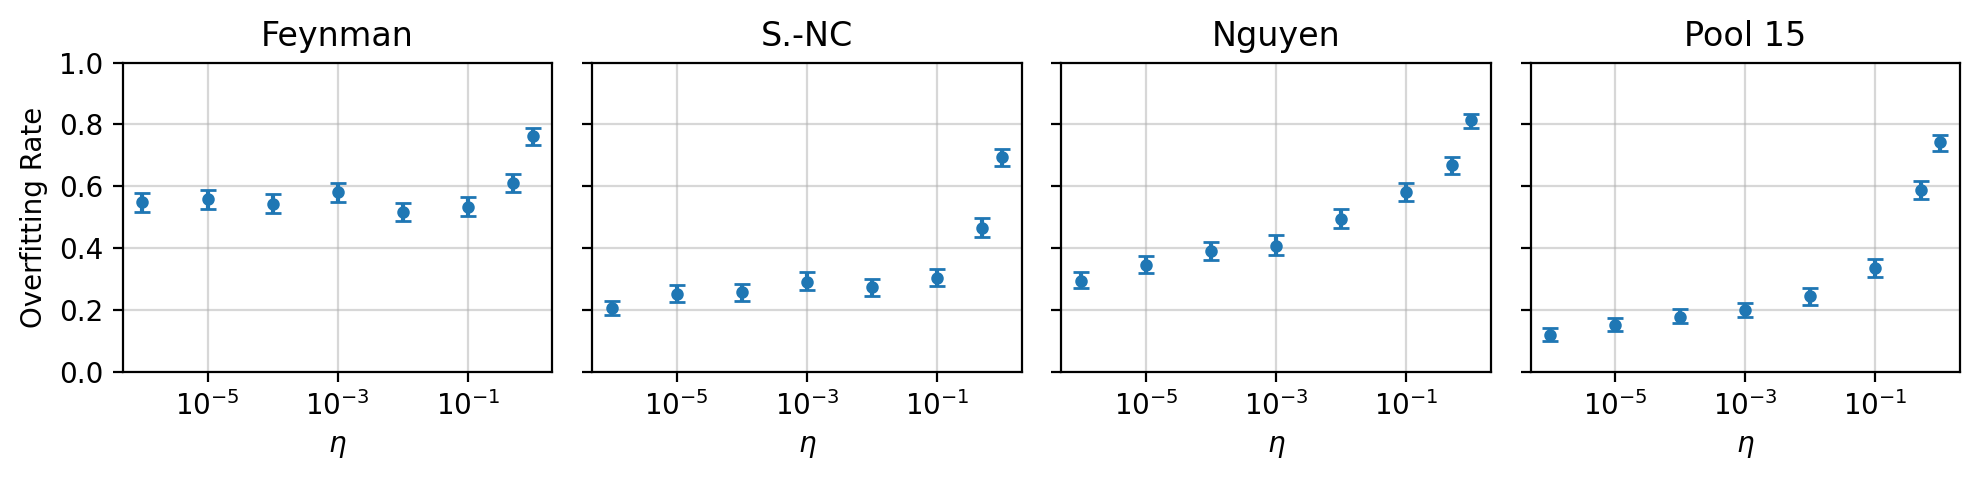

In [73]:
metric = "is_overfit"
noise_levels = [configs[model]['noise_level'] for model in array_dfs.keys()]

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200, sharey=True)

for i, test_set in enumerate(summary_tables[metric]['mean']['median'].columns):
    ax = axes[i]
    data = summary_tables[metric]['mean']['median'][test_set]
    lower = summary_tables[metric]['mean']['lower'][test_set]
    upper = summary_tables[metric]['mean']['upper'][test_set]
    ax.errorbar(noise_levels, data, yerr=[data - lower, upper - data], fmt='.', markersize=7, capsize=3)
    ax.set_xscale('log')
    ax.set_xlabel('$\\eta$')
    ax.set_title(TEST_SET_TITLES[test_set])
    ax.grid(alpha=0.5)
    ax.set_ylim(0, 1)
    
axes[0].set_ylabel('Overfitting Rate')
fig.tight_layout()

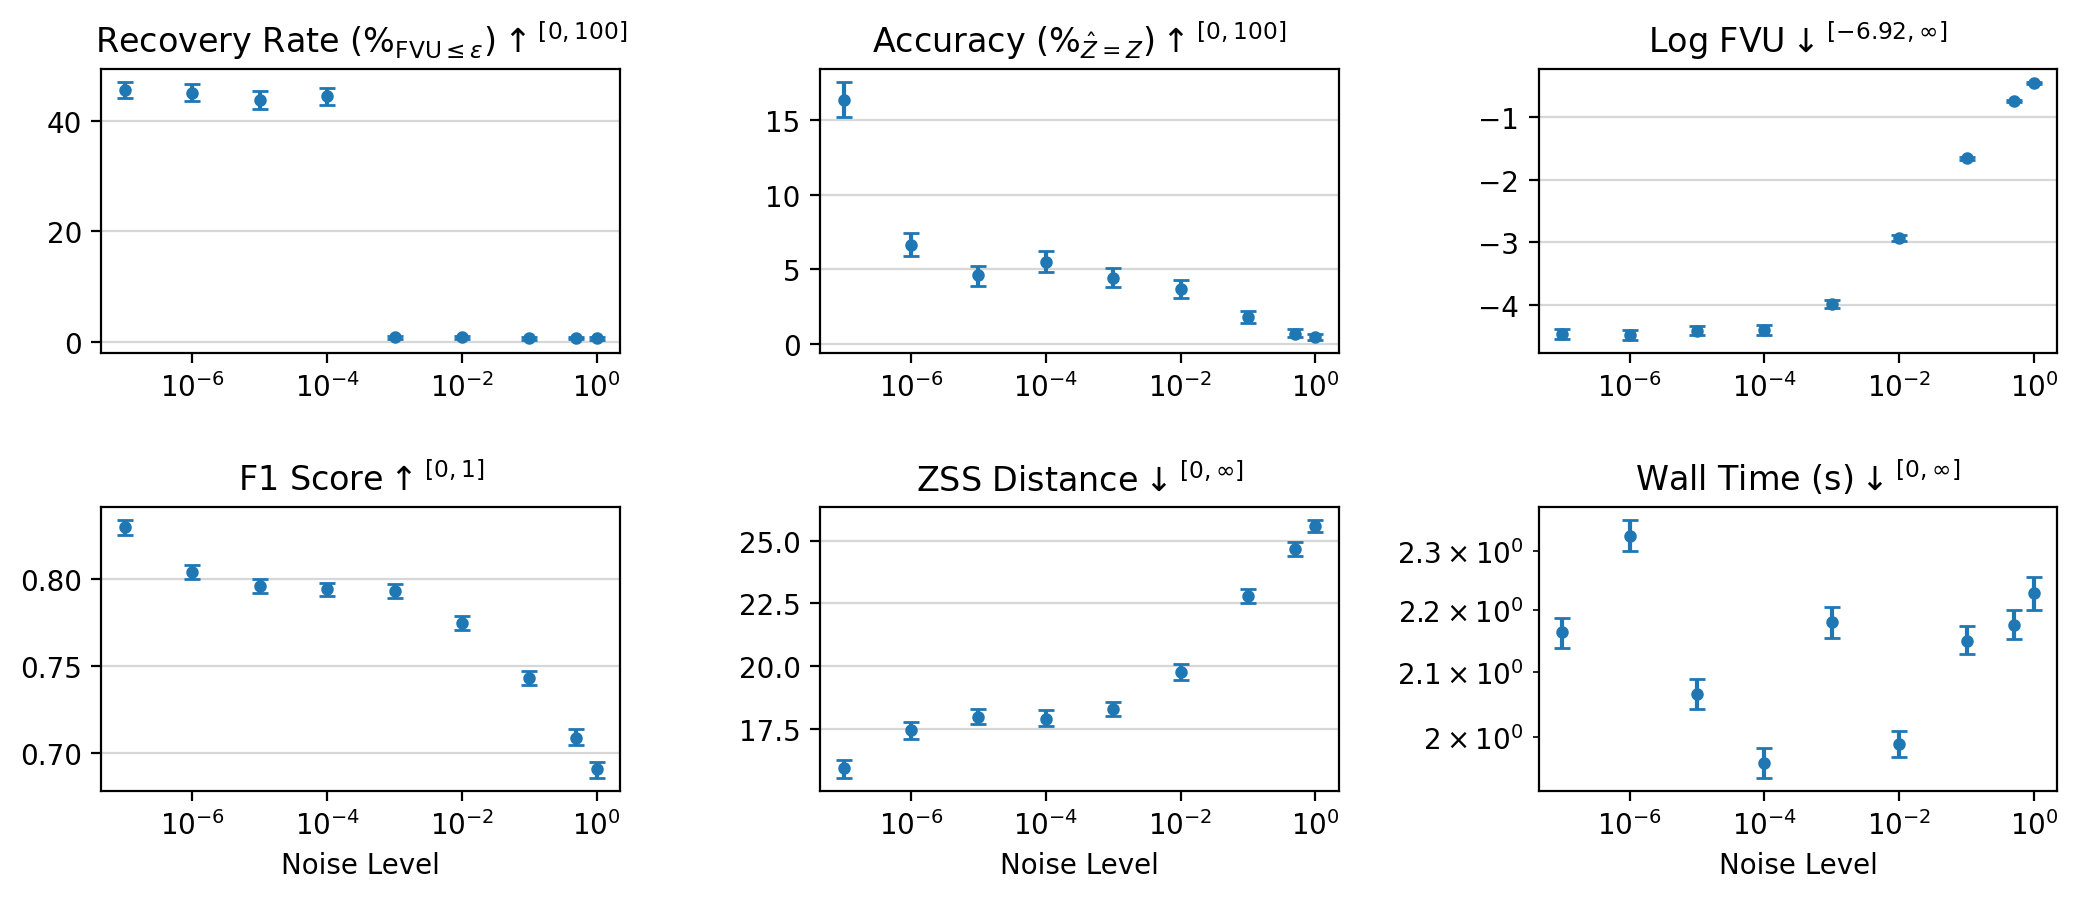

In [74]:
show_metric_list = ['FVU-eps_accuracy', 'accuracy_best_beam', 'log_fvu', 'f1_score_best_beam', 'tree_edit_distance_best_beam', 'wall_time']
objective_list = ['max', 'max', 'min', 'max', 'min', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'Log FVU', 'F1 Score', 'ZSS Distance', 'Wall Time (s)']
bounds_list = [(0, 100), (0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, 1), (0, None), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 100, 1, 1, 1, 1]
yscale_list = ['linear', 'linear', 'linear', 'linear', 'linear', 'log']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = np.array([configs[model]['noise_level'] for model in array_dfs.keys()])
x[0] += 1e-7

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):
    y = total_summary_tables[sub_metric]['median'].T.loc[show_metric] * factor
    y_lower = total_summary_tables[sub_metric]['lower'].T.loc[show_metric] * factor
    y_upper = total_summary_tables[sub_metric]['upper'].T.loc[show_metric] * factor

    ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
    ax.set_xscale('log', base=10)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    # ax.set_xticks(x)
    # ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Noise Level')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y')

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_errorbars.svg'))

In [75]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_1002/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:04,  6.38it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 12%|█▎        | 4/32 [00:00<00:05,  4.87it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered 

In [76]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [77]:
from matplotlib.colors import LogNorm

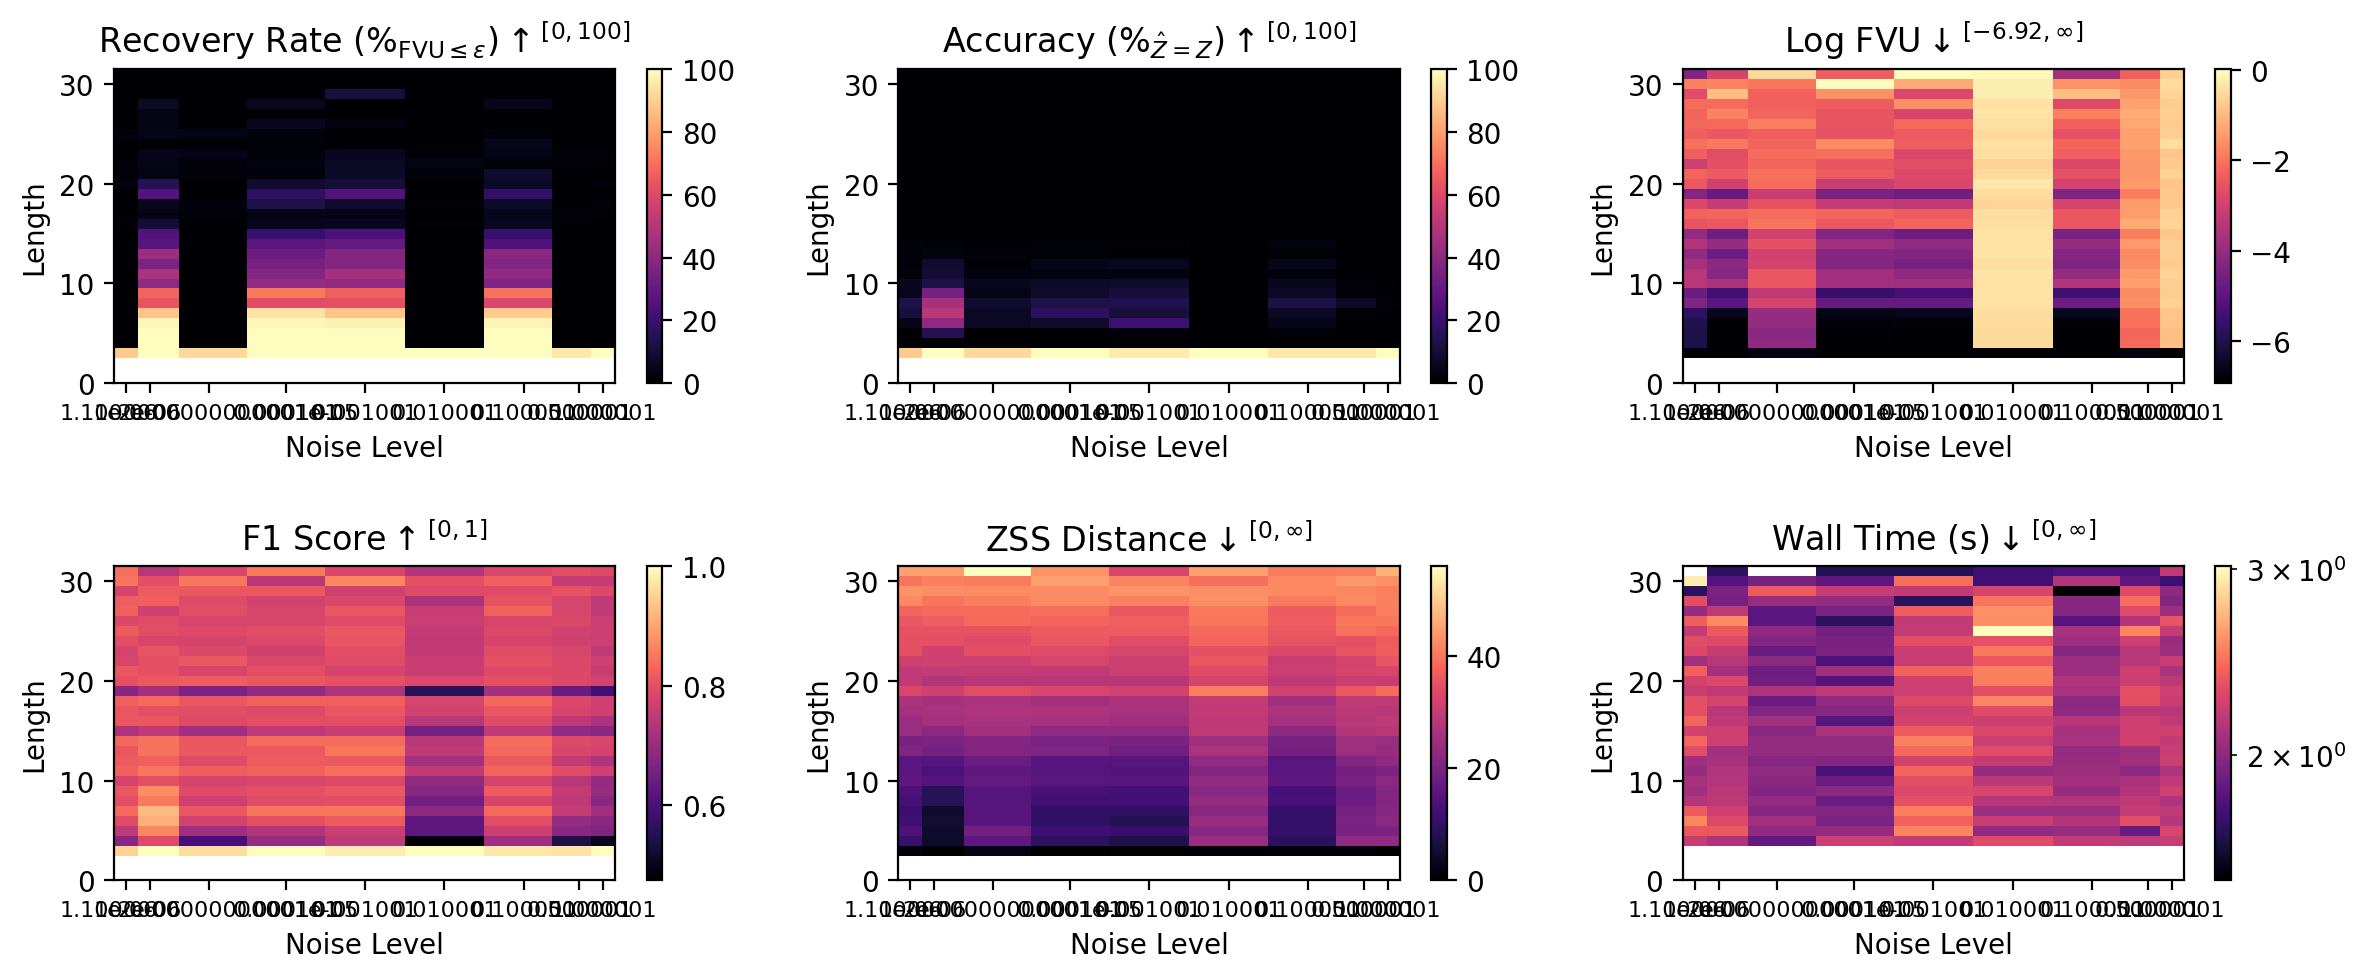

In [78]:
show_metric_list = ['FVU-eps_accuracy', 'accuracy_best_beam', 'log_fvu', 'f1_score_best_beam', 'tree_edit_distance_best_beam', 'wall_time']
objective_list = ['max', 'max', 'min', 'max', 'min', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'Log FVU', 'F1 Score', 'ZSS Distance', 'Wall Time (s)']
bounds_list = [(0, 100), (0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, 1), (0, None), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 100, 1, 1, 1, 1]
log_norm_list = [False, False, False, False, False, True]
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['noise_level'] for model in MODELS]) + 1e-6
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Noise Level')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))